# Phishing Detection

As each coin has two sides, so does technology. On one hand, with the advancement in technology the lives are getting better, on the other hand, the ill use of technology is also increasing. The suspicious activities are increasing ranging from dos attacks, phishing, hacking etc. In this hackathon, we are concerned with the increasing phishing attacks.


Typically, Phishing is a type of social engineering where an attacker sends a fraudulent (e.g., spoofed, fake, or otherwise deceptive) message designed to trick a person into revealing sensitive information to the attacker or to deploy malicious software on the victim's infrastructure like ransomware.


**Task:**

The candidates have to read the data and create a model based on the data analysis to identify if the website is legitimate or a phishing website. The Result will be determined by the two values [1, -1] where 1 represent the legitimate and -1 represents phishing


**Data Description:**

The data set consists of 30 features of a phishing website. The value of attributes can be [1, 0, -1] except the key value which is incremental.

*  1 represents the legitimate
*  0 represents suspicious
* -1 represents phishing

## Submission
1. Output file generated by the model.
2. Source Code file or .ipynb file or Report
3. Report or Presentation with model explanation
4. Demonstration Video (If Possible)

## Evaluation Metric
- Correctness of code / Score Received
- Source or .ipynb file Submitted
- Report or Presentation with model explanation

In [117]:
!wget https://www.techgig.com/files/DataScienceData/344575/Phising_Training_Dataset.csv
!wget https://www.techgig.com/files/DataScienceData/344575/Phising_Testing_Dataset.csv
!wget https://www.techgig.com/files/DataScienceData/344575/sample_submission.csv
!pip install sweetviz

--2022-06-19 04:07:26--  https://www.techgig.com/files/DataScienceData/344575/Phising_Training_Dataset.csv
Resolving www.techgig.com (www.techgig.com)... 23.205.107.91, 23.205.107.77, 2600:1408:c400:16::17d4:f80f, ...
Connecting to www.techgig.com (www.techgig.com)|23.205.107.91|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘Phising_Training_Dataset.csv.1’

Phising_Training_Da     [ <=>                ] 685.46K  --.-KB/s    in 0.1s    

2022-06-19 04:07:26 (6.68 MB/s) - ‘Phising_Training_Dataset.csv.1’ saved [701909]

--2022-06-19 04:07:26--  https://www.techgig.com/files/DataScienceData/344575/Phising_Testing_Dataset.csv
Resolving www.techgig.com (www.techgig.com)... 23.205.107.91, 23.205.107.77, 2600:1408:c400:16::17d4:f80f, ...
Connecting to www.techgig.com (www.techgig.com)|23.205.107.91|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘Phising_Testing_Dataset.cs

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sweetviz as eda
import seaborn as sns

In [2]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# set pandas options
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_columns", None)

# /content/drive/MyDrive/TechGig_HPE_ML_2022
root = "/content/drive/MyDrive/TechGig_HPE_ML_2022/%s"
root = "./%s"

from joblib import dump, load
fontdict = dict(color="green", fontsize=17, fontweight="bold")

# Defining Custom functions


In [3]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics

# model building helpers
def performance(logreg, X_train, X_test, y_train, y_test, render=False):
    y_pred_train = logreg.predict(X_train)
    y_pred_test = logreg.predict(X_test)

    metric = dict()
    # plain model score
    metric["Classification report"] = dict(
        train=classification_report(y_train, y_pred_train, output_dict=True),
        test=classification_report(y_test, y_pred_test, output_dict=True)
    )
    if render:
        print("Training: ")
        display(pd.DataFrame(metric["Classification report"]["train"]))
        print("Testing: ")
        display(pd.DataFrame(metric["Classification report"]["test"]))
    return metric

def draw_roc(model, x, y):
    actual, probs = y, model.predict_proba(x)[:,1]
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.4f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None


# Quantile based flooring and capping
def outlier_capping(series, low=0.05, high=0.95):
    # Computing 10th, 90th percentiles and replacing the outliers
    low_percentile = np.percentile(series.values, low*100)
    high_percentile = np.percentile(series.values, high*100)
    # print(col, low_percentile, high_percentile)
    arr = series.values
    arr = np.where(arr < low_percentile, low_percentile, arr)
    arr = np.where(arr > high_percentile, high_percentile, arr)
    return arr


def tuning_performance(model_cv, param, metrics, title):
    cv_df = pd.DataFrame(model_cv.cv_results_)
    ax = cv_df.groupby(f'param_{param}')[metrics].mean().plot(figsize=[8,5])
    ax.set_title(title, fontdict=fontdict)
    plt.show()

In [4]:
# Some function for faster feature searching
import statsmodels.api as sm
from   statsmodels.stats.outliers_influence import variance_inflation_factor
from   sklearn.metrics import r2_score

def vif_p_value_analysis(X, model, key_p_val='P>|z|'):
    """
        Analyse VIF(multicollenirity) and p-value(significance)

        Args:
          X: The dataframe used to train
          model: A statsmodel instance that are trained with X
          key_p_val: For GML() this value is `'P>|z|'`. Specify diffenent value for other models.
        
        Returns:
            DataFrame - Contains VIF(multicollenirity) and p-value(significance) values
                for each predictors.
    """
    # generate VIF for all the features
    vif = pd.DataFrame()
    vif['Features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values,i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by="VIF", ascending=False, ignore_index=True)
    
    # Convert the model summary to a dataframe
    results_as_html = model.summary().tables[1].as_html()
    model_summary_df = pd.read_html(results_as_html, header=0)[0]

    # capture the features and the p-values(significances)
    p_values = model_summary_df[['Unnamed: 0', key_p_val, 'coef']]
    p_values['Features'] = p_values['Unnamed: 0']
    p_values.drop(columns='Unnamed: 0', inplace=True)

    # Join the dataframes
    vif_p_value = pd.merge(vif, p_values, on="Features")
    return vif_p_value

def feature_eleminiation_suggestion(vif_p, p_val_cutoff=0.05, vif_cutoff=5, key_p_val='P>|z|', echo=True):
    """
    This function automatically analysis p-value and VIF and provide dropping suggestion.
    with reason.

    Args:
      vif_p: A dataframe returnd by vif_p_value_analysis() function
      p_val_cutoff: The cutoff value for `variable significance`. Default is 5%.
      vif_cutoff: The cutoff value for feature `multi-collinearity`. Default is 5.
      key_p_val: For GLM() this value is `'P>|z|'`. Specify diffenent value for other models.

    Returns:
      tuple: (feature_name, value, flag)
              feature_name: The name of the feature
              value: The read value
              flag: p_value or VIF
  """
    def print_(*args):
      if echo:
        print(*args)

    high_p = vif_p[(vif_p[key_p_val] >= p_val_cutoff) & (vif_p['Features'] != 'const')].sort_values(by=key_p_val, ascending=False, ignore_index=True)
    high_vif = vif_p[(vif_p['VIF'] >= vif_cutoff) & (vif_p['Features'] != 'const')].sort_values(by='VIF', ascending=False, ignore_index=True)

    if high_p.shape[0]:
      print_(f"D R O P     S U G G E S T I O N\n")
      top = high_p.loc[0, ['Features', key_p_val]]
      features = top['Features']
      p_value  = top[key_p_val]
      print_(f"High p-value for '{features}'={p_value}. Drop Insignificant Variable-'{features}'.")
      return features, p_value, "p_value"
    elif high_vif.shape[0]:
      print_(f"D R O P     S U G G E S T I O N\n")
      top = high_vif.loc[0, ['Features', 'VIF']]
      features = top['Features']
      vif  = top['VIF']
      print_(f"High VIF for '{features}'={vif}. Drop multicollineared Variable-'{features}'.")
      return features, vif, "vif"

In [5]:
# Manual feature elemination
import time
import datetime

def manual_feature_elemination(x, y, model_no, p_value_cutoff, vif_cutoff, feature_count=[], key_p_val='P>|z|', save_models=False):
    model = None
    multi_models = []
    train_cols = x.columns
    start_time = time.time()
    print("Started: ", datetime.datetime.now())
    while model is None:
      st = time.time()
      print("\n\n==========================================")
      print("Started: ", datetime.datetime.now())
      print(f"Model:{model_no}\nFeatures({len(train_cols)}):")
      # print features
      #display(train_cols)
      # prepare and train model with the given features
      X_train_sm = sm.add_constant(x[train_cols])
      algo = sm.GLM(y, X_train_sm, family = sm.families.Binomial())
      logm2 = algo.fit()
      # calculate auc score
      reg = LogisticRegression(random_state=42)
      reg.fit(x[train_cols], y)
      probs = reg.predict_proba(x[train_cols])[:, 1]
      auc_score = metrics.roc_auc_score(y, probs )
      # gather VIF and p-values for the fetures
      vif_p_df = vif_p_value_analysis(X_train_sm, logm2, key_p_val=key_p_val)
      print("AUC: ", round(auc_score, 4))
      #display(logm2.summary())
      display(vif_p_df)
      # Analyse if we can drop any features or not for improvement
      status = feature_eleminiation_suggestion(vif_p_df, p_val_cutoff=p_value_cutoff, vif_cutoff=vif_cutoff, key_p_val=key_p_val)
      if len(train_cols) in feature_count or save_models:
        multi_models.append((logm2, train_cols, model_no, status, auc_score, reg))
        print(f"Checkpoint -- Model No:{model_no}, Feature count:{len(train_cols)}")
      if status is None:
        model = logm2
        multi_models.append((logm2, train_cols, model_no, status, auc_score, reg))
        print("No more improvements. Stopping here.")
      else:
        # removing the bad feature
        train_cols = [col for col in train_cols if status[0] != col]
      print(f"Model:{model_no} took {time.time() - st} sec")
      print("Ended: ", datetime.datetime.now())
      model_no += 1
    print(f"Process took {time.time() - start_time} sec")
    print("Ended: ", datetime.datetime.now())
    return multi_models

# Data understanding

In [6]:
# read the data
train = pd.read_csv("./Phising_Training_Dataset.csv")
test = pd.read_csv("./Phising_Testing_Dataset.csv")

In [7]:
# shape
train.shape, test.shape

((8955, 32), (2100, 31))

## Look for datatype and null values

In [8]:
# info
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8955 entries, 0 to 8954
Data columns (total 32 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   key                          8955 non-null   int64
 1   having_IP                    8955 non-null   int64
 2   URL_Length                   8955 non-null   int64
 3   Shortining_Service           8955 non-null   int64
 4   having_At_Symbol             8955 non-null   int64
 5   double_slash_redirecting     8955 non-null   int64
 6   Prefix_Suffix                8955 non-null   int64
 7   having_Sub_Domain            8955 non-null   int64
 8   SSLfinal_State               8955 non-null   int64
 9   Domain_registeration_length  8955 non-null   int64
 10  Favicon                      8955 non-null   int64
 11  port                         8955 non-null   int64
 12  HTTPS_token                  8955 non-null   int64
 13  Request_URL                  8955 non-null   int

* The dataset is clean

In [9]:
# train dataset9
train.head()

key  having_IP  URL_Length  Shortining_Service  having_At_Symbol  \
0  12344         -1           1                   1                 1   
1  12345          1           1                   1                 1   
2  12346          1           0                   1                 1   
3  12347          1           0                   1                 1   
4  12348          1           0                  -1                 1   

   double_slash_redirecting  Prefix_Suffix  having_Sub_Domain  SSLfinal_State  \
0                        -1             -1                 -1              -1   
1                         1             -1                  0               1   
2                         1             -1                 -1              -1   
3                         1             -1                 -1              -1   
4                         1             -1                  1               1   

   Domain_registeration_length  Favicon  port  HTTPS_token  Request_URL  \
0                           -1        1     1           -1            1   
1                           -1        1     1           -1            1   
2                           -1        1     1           -1            1   
3                            1        1     1           -1           -1   
4                           -1        1     1            1            1   

   URL_of_Anchor  Links_in_tags  SFH  Submitting_to_email  Abnormal_URL  \
0             -1              1   -1                   -1            -1   
1              0             -1   -1                    1             1   
2              0             -1   -1                   -1            -1   
3              0              0   -1                    1             1   
4              0              0   -1                    1             1   

   Redirect  on_mouseover  RightClick  popUpWidnow  Iframe  age_of_domain  \
0         0             1           1            1       1             -1   
1         0             1           1            1       1             -1   
2         0             1           1            1       1              1   
3         0             1           1            1       1             -1   
4         0            -1           1           -1       1             -1   

   DNSRecord  web_traffic  Page_Rank  Google_Index  Links_pointing_to_page  \
0         -1           -1         -1             1                       1   
1         -1            0         -1             1                       1   
2         -1            1         -1             1                       0   
3         -1            1         -1             1                      -1   
4         -1            0         -1             1                       1   

   Statistical_report  Result  
0                  -1      -1  
1                   1      -1  
2                  -1      -1  
3                   1      -1  
4                   1       1

In [10]:
# test dataset
test.head()

key  having_IP  URL_Length  Shortining_Service  having_At_Symbol  \
0  21338          1           1                   1                 1   
1  21339          1          -1                   1                 1   
2  21340          1          -1                   1                 1   
3  21341         -1          -1                  -1                 1   
4  21342          1          -1                   1                 1   

   double_slash_redirecting  Prefix_Suffix  having_Sub_Domain  SSLfinal_State  \
0                         1              1                 -1               1   
1                         1             -1                  0              -1   
2                         1             -1                  0               0   
3                        -1             -1                 -1              -1   
4                         1             -1                  1               1   

   Domain_registeration_length  Favicon  port  HTTPS_token  Request_URL  \
0                           -1        1     1            1            1   
1                            1        1     1            1            1   
2                           -1       -1    -1            1           -1   
3                            1       -1    -1           -1           -1   
4                           -1        1     1            1            1   

   URL_of_Anchor  Links_in_tags  SFH  Submitting_to_email  Abnormal_URL  \
0              0              0    1                    1             1   
1             -1             -1   -1                    1             1   
2             -1             -1   -1                   -1             1   
3             -1              1   -1                   -1            -1   
4              0              1   -1                    1             1   

   Redirect  on_mouseover  RightClick  popUpWidnow  Iframe  age_of_domain  \
0         0             1           1            1       1              1   
1         0             1           1            1       1             -1   
2         0            -1          -1           -1      -1              1   
3         1            -1           1           -1      -1              1   
4         0             1           1            1       1              1   

   DNSRecord  web_traffic  Page_Rank  Google_Index  Links_pointing_to_page  \
0          1            1          1            -1                       0   
1         -1            0         -1            -1                       0   
2         -1            1         -1             1                       1   
3         -1            1         -1             1                       1   
4          1            1         -1             1                       0   

   Statistical_report  
0                   1  
1                   1  
2                  -1  
3                  -1  
4                   1

In [11]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2100 entries, 0 to 2099
Data columns (total 31 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   key                          2100 non-null   int64
 1   having_IP                    2100 non-null   int64
 2   URL_Length                   2100 non-null   int64
 3   Shortining_Service           2100 non-null   int64
 4   having_At_Symbol             2100 non-null   int64
 5   double_slash_redirecting     2100 non-null   int64
 6   Prefix_Suffix                2100 non-null   int64
 7   having_Sub_Domain            2100 non-null   int64
 8   SSLfinal_State               2100 non-null   int64
 9   Domain_registeration_length  2100 non-null   int64
 10  Favicon                      2100 non-null   int64
 11  port                         2100 non-null   int64
 12  HTTPS_token                  2100 non-null   int64
 13  Request_URL                  2100 non-null   int

## Data Anatomy

- 30 Features
- `key` un-usable variable
- `Result` the target variable

In [12]:
# drop key column
train_key = train['key']
train.drop(columns=['key'], inplace=True)
train.head()

having_IP  URL_Length  Shortining_Service  having_At_Symbol  \
0         -1           1                   1                 1   
1          1           1                   1                 1   
2          1           0                   1                 1   
3          1           0                   1                 1   
4          1           0                  -1                 1   

   double_slash_redirecting  Prefix_Suffix  having_Sub_Domain  SSLfinal_State  \
0                        -1             -1                 -1              -1   
1                         1             -1                  0               1   
2                         1             -1                 -1              -1   
3                         1             -1                 -1              -1   
4                         1             -1                  1               1   

   Domain_registeration_length  Favicon  port  HTTPS_token  Request_URL  \
0                           -1        1     1           -1            1   
1                           -1        1     1           -1            1   
2                           -1        1     1           -1            1   
3                            1        1     1           -1           -1   
4                           -1        1     1            1            1   

   URL_of_Anchor  Links_in_tags  SFH  Submitting_to_email  Abnormal_URL  \
0             -1              1   -1                   -1            -1   
1              0             -1   -1                    1             1   
2              0             -1   -1                   -1            -1   
3              0              0   -1                    1             1   
4              0              0   -1                    1             1   

   Redirect  on_mouseover  RightClick  popUpWidnow  Iframe  age_of_domain  \
0         0             1           1            1       1             -1   
1         0             1           1            1       1             -1   
2         0             1           1            1       1              1   
3         0             1           1            1       1             -1   
4         0            -1           1           -1       1             -1   

   DNSRecord  web_traffic  Page_Rank  Google_Index  Links_pointing_to_page  \
0         -1           -1         -1             1                       1   
1         -1            0         -1             1                       1   
2         -1            1         -1             1                       0   
3         -1            1         -1             1                      -1   
4         -1            0         -1             1                       1   

   Statistical_report  Result  
0                  -1      -1  
1                   1      -1  
2                  -1      -1  
3                   1      -1  
4                   1       1

# Drop Duplicate Entries

In [13]:
# drop duplicate entries
train_unik = train.drop_duplicates()
train_unik.shape, train.shape

((5214, 31), (8955, 31))

In [14]:
# class value counts
train_unik.Result.value_counts()

-1    2639
 1    2575
Name: Result, dtype: int64

# Exploratery Data Analysis

In [ ]:
# correlation headmap
corr = train_unik.corr()
plt.figure(figsize=[25, 10])
sns.heatmap(corr, annot=True, cmap="RdYlBu")
plt.title("Feature pearson-r correlations:")
plt.show()

- There are **9 features** is highly correlated with `Result`, target variable, feature
    1. `Prefix_Suffix`
    1. `having_Sub_Domain`
    1. `SSLfinal_State`
    1. `Domain_registeration_length`
    1. `Request_URL`
    1. `URL_of_Anchor`
    1. `Links_in_tags`
    1. `SFH`
    1. `web_traffic`
- Above features has higher potential to identify the `Result` variable accuratly.

                                             |                                   | [  0%]   00:00 -> (? left)


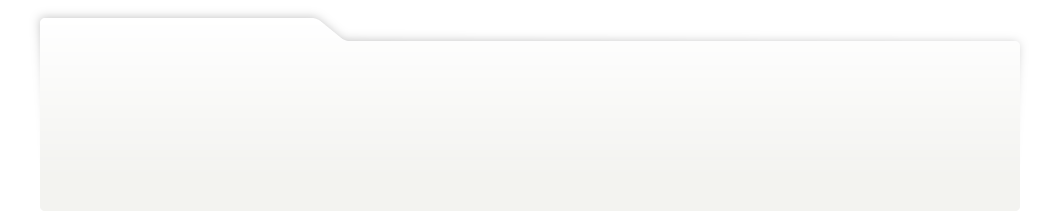
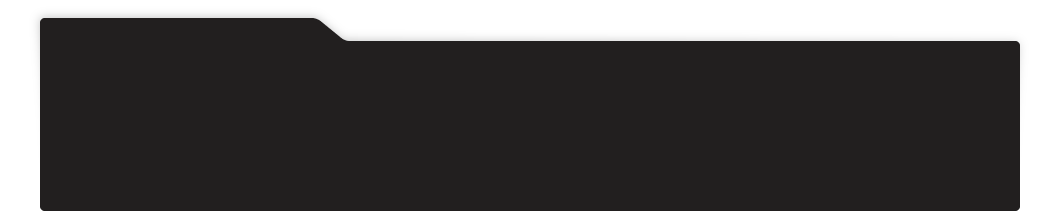
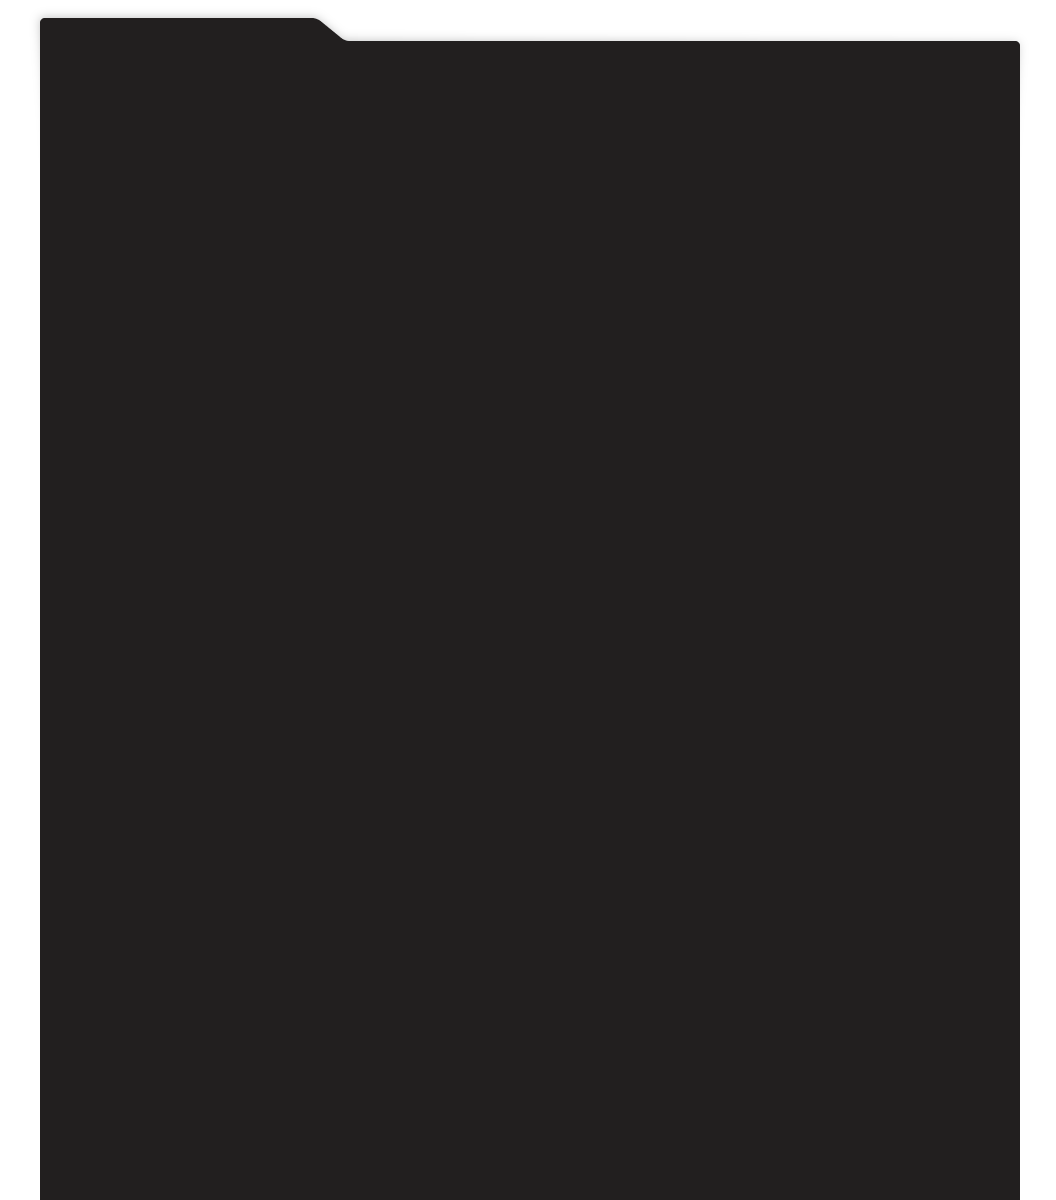
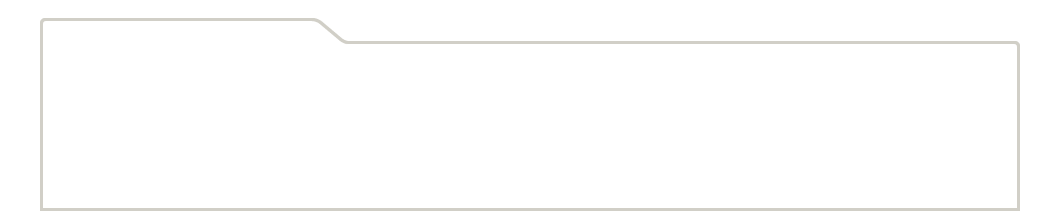
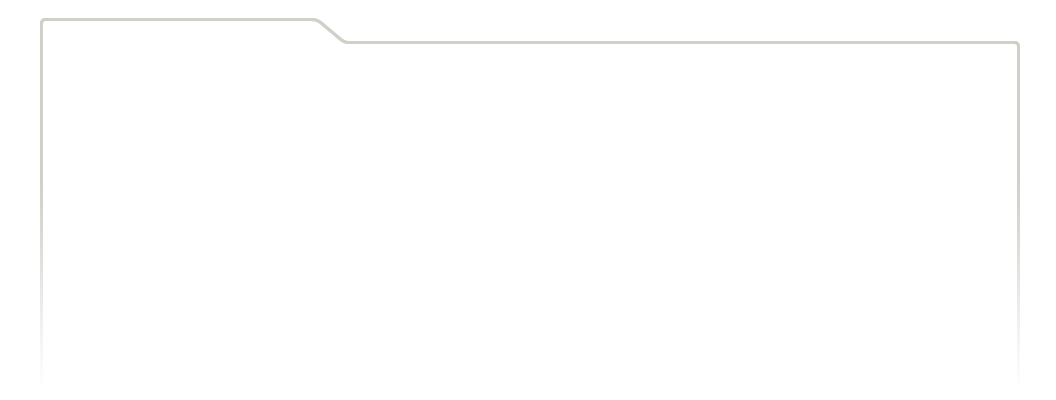
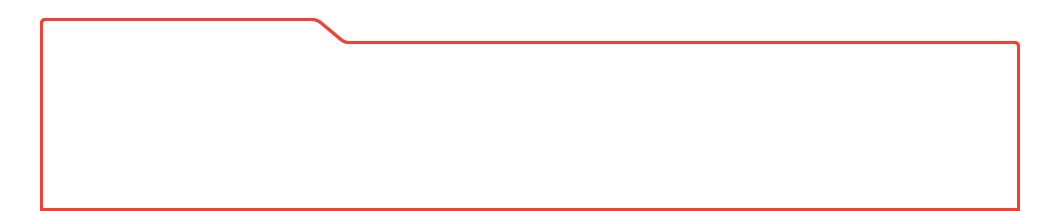
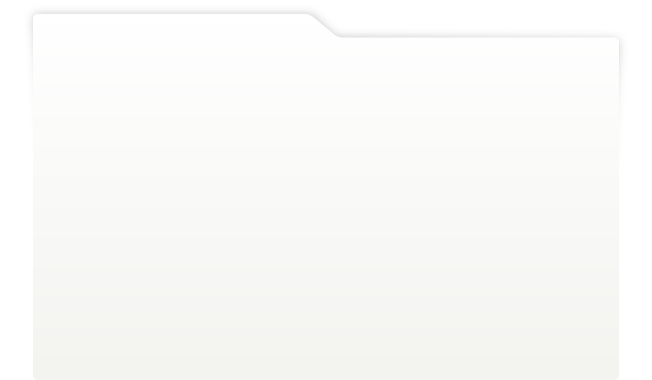
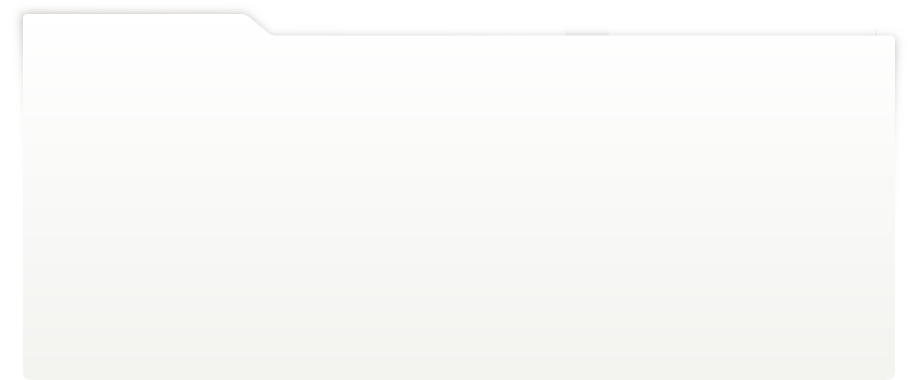
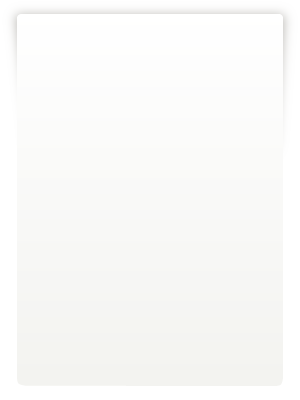
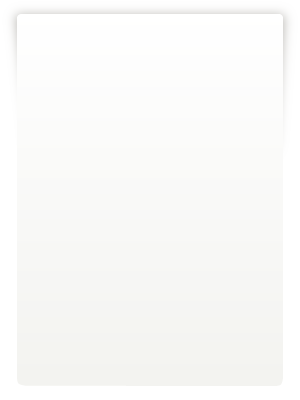
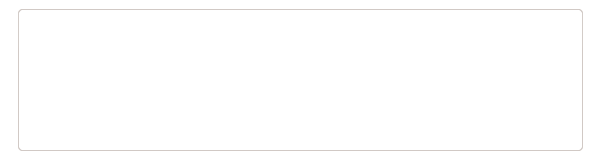
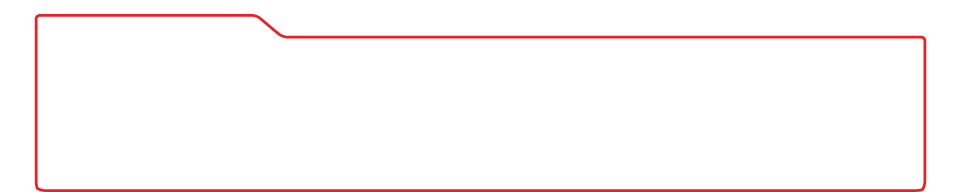
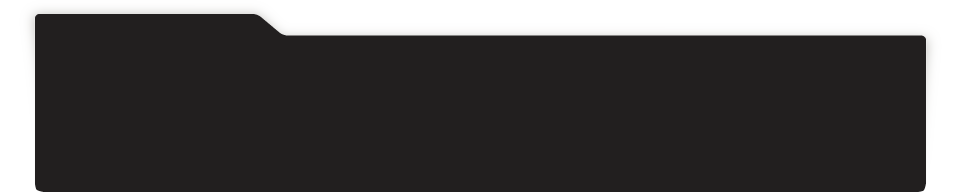
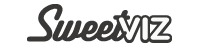
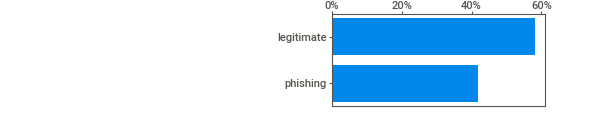
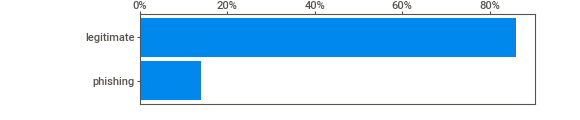
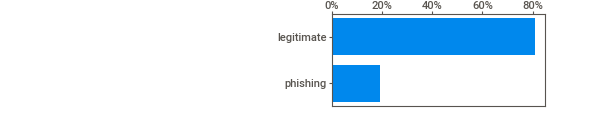
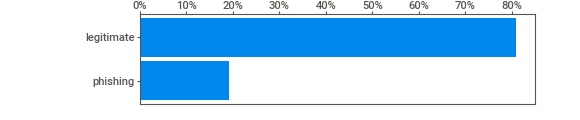
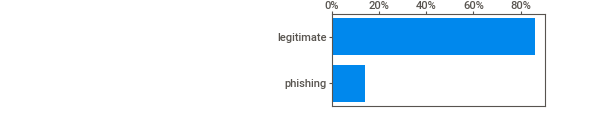
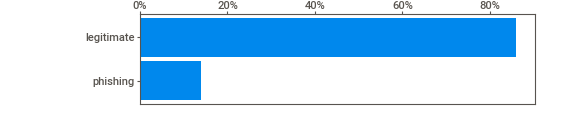
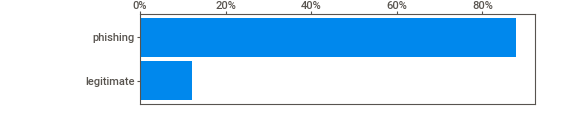
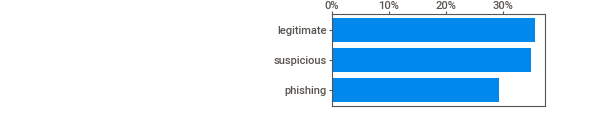
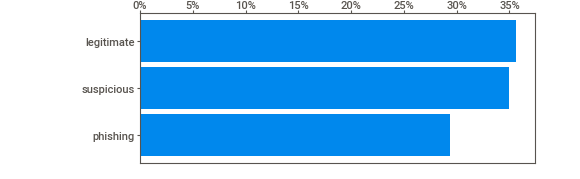
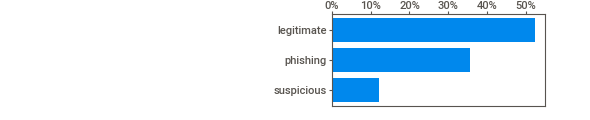
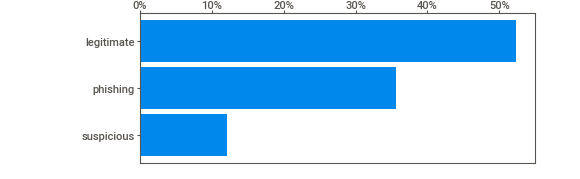
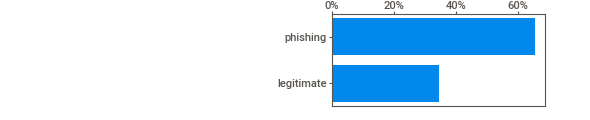
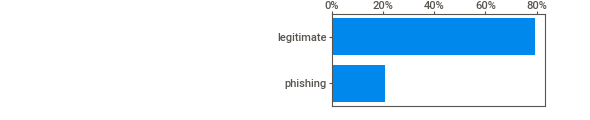
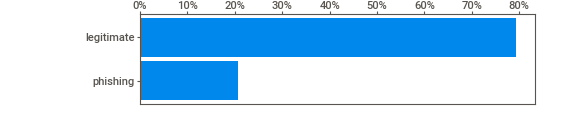
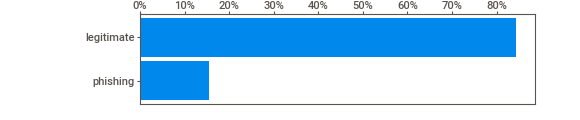
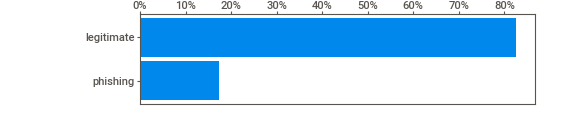
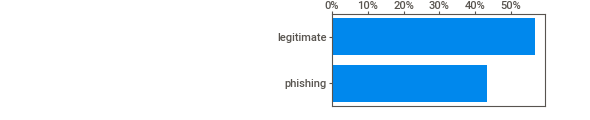
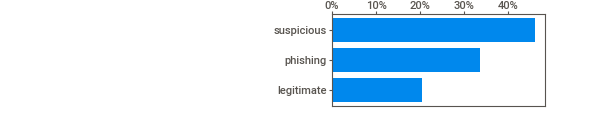
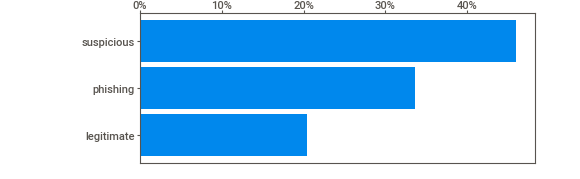
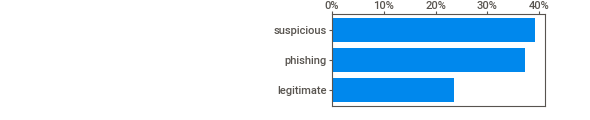
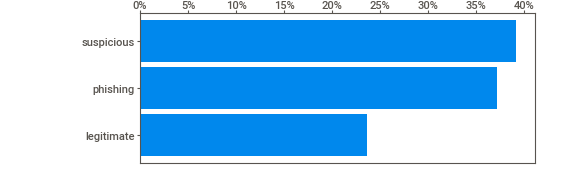
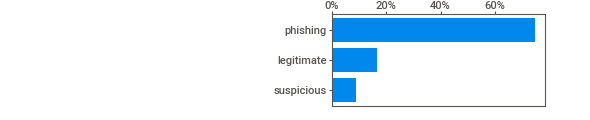
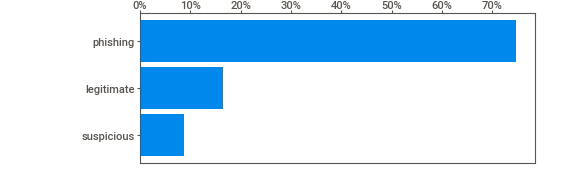
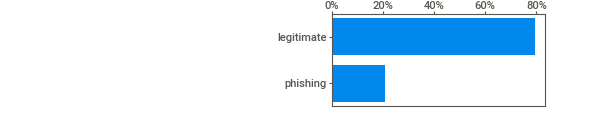
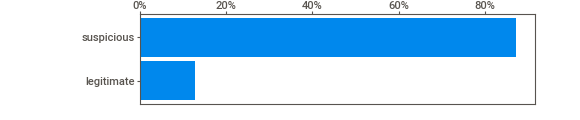
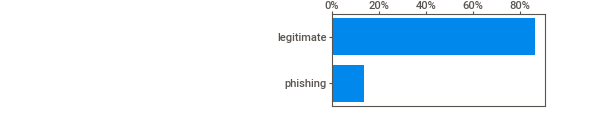
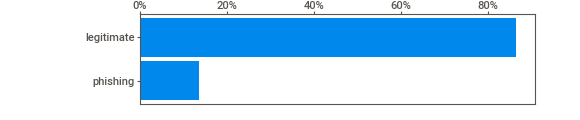
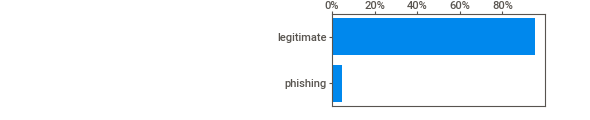
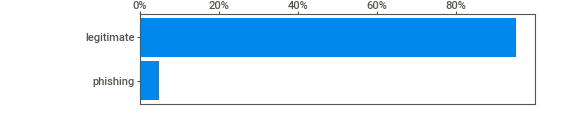
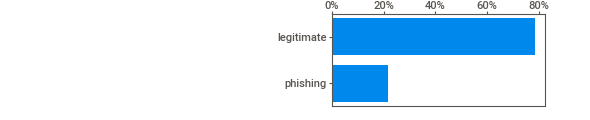
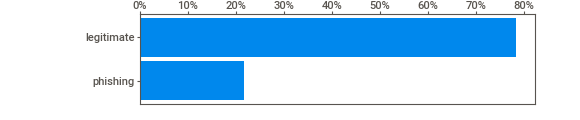
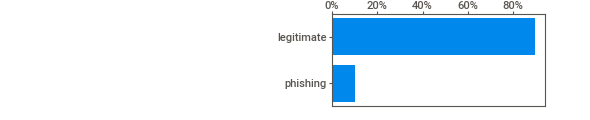
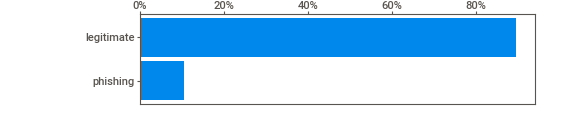
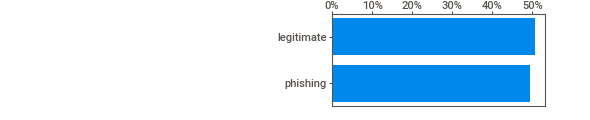
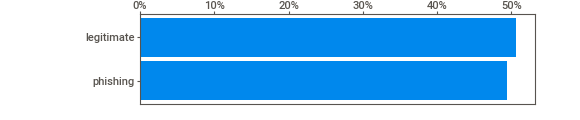
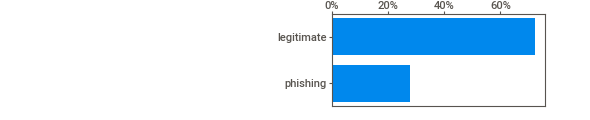
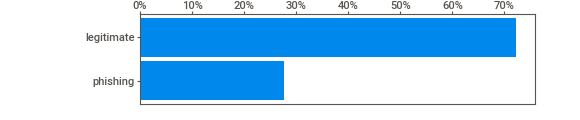
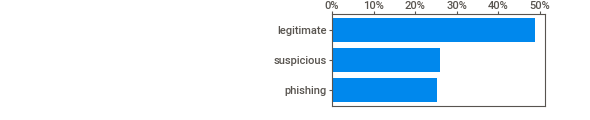
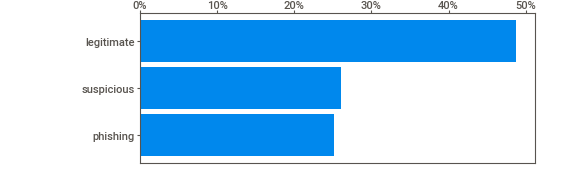
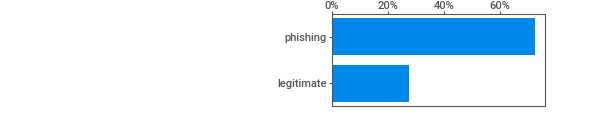
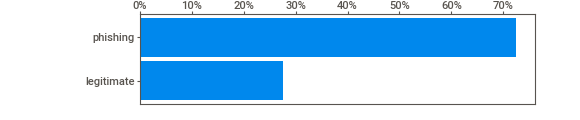
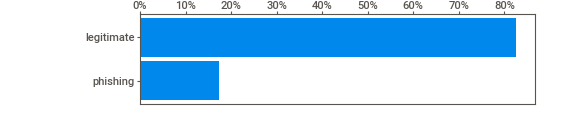
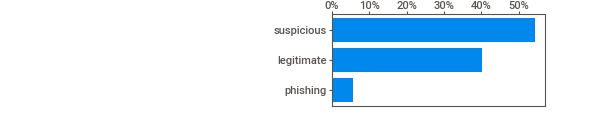
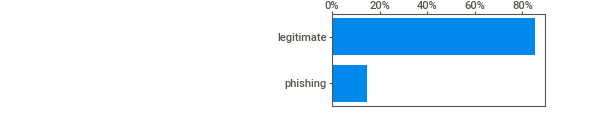
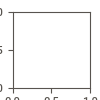

In [ ]:
# sweetviz auto eda
my_report = eda.analyze(train_unik.replace([-1, 0, 1], ["phishing", "suspicious", "legitimate"]))
my_report.show_notebook()

**Result:** Here we have `legitimate: 51%` and `phishing: 49%`. I would say this is a **nice balance** between the classes.


# Expected outcome

- As we can clearly understand that, we are dealing with a binary classification problem.

- Based on my understanding of the given problem we have build a model which can provide us the **lowest** `Recall` score.

# Prepaing Dataset

## Perform ordinal encoding to aid the training process

In [ ]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline

## Define `Phising=1` and `Legitimate=0`

In [ ]:
train_unik.sample(5, random_state=0)

having_IP  URL_Length  Shortining_Service  having_At_Symbol  \
4027          1          -1                   1                 1   
8079         -1          -1                   1                 1   
7046         -1          -1                   1                -1   
2550         -1          -1                  -1                 1   
42            1          -1                   1                 1   

      double_slash_redirecting  Prefix_Suffix  having_Sub_Domain  \
4027                         1             -1                  0   
8079                         1             -1                 -1   
7046                         1             -1                  0   
2550                        -1             -1                  1   
42                           1             -1                 -1   

      SSLfinal_State  Domain_registeration_length  Favicon  port  HTTPS_token  \
4027              -1                            1        1     1            1   
8079              -1                           -1       -1    -1            1   
7046               1                            1       -1    -1            1   
2550               1                           -1        1     1           -1   
42                -1                            1       -1    -1            1   

      Request_URL  URL_of_Anchor  Links_in_tags  SFH  Submitting_to_email  \
4027           -1             -1             -1   -1                    1   
8079            1             -1              0   -1                   -1   
7046           -1             -1              1   -1                   -1   
2550            1              1             -1   -1                    1   
42             -1             -1             -1   -1                   -1   

      Abnormal_URL  Redirect  on_mouseover  RightClick  popUpWidnow  Iframe  \
4027             1         0             1           1            1       1   
8079             1         0             1           1           -1       1   
7046             1         0            -1           1           -1      -1   
2550            -1         1             1           1            1       1   
42              -1         0            -1           1           -1       1   

      age_of_domain  DNSRecord  web_traffic  Page_Rank  Google_Index  \
4027             -1         -1            0         -1             1   
8079              1          1            0         -1            -1   
7046              1          1            1         -1            -1   
2550              1         -1            1         -1             1   
42               -1         -1            1         -1             1   

      Links_pointing_to_page  Statistical_report  Result  
4027                       0                   1      -1  
8079                       0                   1      -1  
7046                       1                   1      -1  
2550                       1                   1       1  
42                        -1                  -1      -1

In [ ]:
# conver (-1 to 1) and (1 to 0) [WARNING!! run this only once]
train_unik["Result"] = train_unik["Result"].apply(lambda x: 1 if x is -1 else 0)
train_unik.sample(5, random_state=0)

C:\Users\dndlssardar\Anaconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


having_IP  URL_Length  Shortining_Service  having_At_Symbol  \
4027          1          -1                   1                 1   
8079         -1          -1                   1                 1   
7046         -1          -1                   1                -1   
2550         -1          -1                  -1                 1   
42            1          -1                   1                 1   

      double_slash_redirecting  Prefix_Suffix  having_Sub_Domain  \
4027                         1             -1                  0   
8079                         1             -1                 -1   
7046                         1             -1                  0   
2550                        -1             -1                  1   
42                           1             -1                 -1   

      SSLfinal_State  Domain_registeration_length  Favicon  port  HTTPS_token  \
4027              -1                            1        1     1            1   
8079              -1                           -1       -1    -1            1   
7046               1                            1       -1    -1            1   
2550               1                           -1        1     1           -1   
42                -1                            1       -1    -1            1   

      Request_URL  URL_of_Anchor  Links_in_tags  SFH  Submitting_to_email  \
4027           -1             -1             -1   -1                    1   
8079            1             -1              0   -1                   -1   
7046           -1             -1              1   -1                   -1   
2550            1              1             -1   -1                    1   
42             -1             -1             -1   -1                   -1   

      Abnormal_URL  Redirect  on_mouseover  RightClick  popUpWidnow  Iframe  \
4027             1         0             1           1            1       1   
8079             1         0             1           1           -1       1   
7046             1         0            -1           1           -1      -1   
2550            -1         1             1           1            1       1   
42              -1         0            -1           1           -1       1   

      age_of_domain  DNSRecord  web_traffic  Page_Rank  Google_Index  \
4027             -1         -1            0         -1             1   
8079              1          1            0         -1            -1   
7046              1          1            1         -1            -1   
2550              1         -1            1         -1             1   
42               -1         -1            1         -1             1   

      Links_pointing_to_page  Statistical_report  Result  
4027                       0                   1       1  
8079                       0                   1       1  
7046                       1                   1       1  
2550                       1                   1       0  
42                        -1                  -1       1

## Prepare `X` and `y`

In [ ]:
# prepare variables
X = train_unik.drop(columns=["Result"])
y = train_unik.Result

## Ordinal Encoding

In [ ]:
# encoder pipeline
enc = Pipeline(steps=[
    ("encoder", OrdinalEncoder()),
])
# perform ordinal encoding
enc_arr = enc.fit_transform(X)
X = X.copy()
# encode
X.loc[:,:] = enc_arr

# prepare test data
# drop key column
test_key = test['key']
test.drop(columns=['key'], inplace=True)
# perform ordinal encoding
enc_test_arr = enc.transform(test)
test_enc = test.copy()
# encode
test_enc.loc[:,:] = enc_test_arr
test_enc.head()

having_IP  URL_Length  Shortining_Service  having_At_Symbol  \
0        1.0         2.0                 1.0               1.0   
1        1.0         0.0                 1.0               1.0   
2        1.0         0.0                 1.0               1.0   
3        0.0         0.0                 0.0               1.0   
4        1.0         0.0                 1.0               1.0   

   double_slash_redirecting  Prefix_Suffix  having_Sub_Domain  SSLfinal_State  \
0                       1.0            1.0                0.0             2.0   
1                       1.0            0.0                1.0             0.0   
2                       1.0            0.0                1.0             1.0   
3                       0.0            0.0                0.0             0.0   
4                       1.0            0.0                2.0             2.0   

   Domain_registeration_length  Favicon  port  HTTPS_token  Request_URL  \
0                          0.0      1.0   1.0          1.0          1.0   
1                          1.0      1.0   1.0          1.0          1.0   
2                          0.0      0.0   0.0          1.0          0.0   
3                          1.0      0.0   0.0          0.0          0.0   
4                          0.0      1.0   1.0          1.0          1.0   

   URL_of_Anchor  Links_in_tags  SFH  Submitting_to_email  Abnormal_URL  \
0            1.0            1.0  2.0                  1.0           1.0   
1            0.0            0.0  0.0                  1.0           1.0   
2            0.0            0.0  0.0                  0.0           1.0   
3            0.0            2.0  0.0                  0.0           0.0   
4            1.0            2.0  0.0                  1.0           1.0   

   Redirect  on_mouseover  RightClick  popUpWidnow  Iframe  age_of_domain  \
0       0.0           1.0         1.0          1.0     1.0            1.0   
1       0.0           1.0         1.0          1.0     1.0            0.0   
2       0.0           0.0         0.0          0.0     0.0            1.0   
3       1.0           0.0         1.0          0.0     0.0            1.0   
4       0.0           1.0         1.0          1.0     1.0            1.0   

   DNSRecord  web_traffic  Page_Rank  Google_Index  Links_pointing_to_page  \
0        1.0          2.0        1.0           0.0                     1.0   
1        0.0          1.0        0.0           0.0                     1.0   
2        0.0          2.0        0.0           1.0                     2.0   
3        0.0          2.0        0.0           1.0                     2.0   
4        1.0          2.0        0.0           1.0                     1.0   

   Statistical_report  
0                 1.0  
1                 1.0  
2                 0.0  
3                 0.0  
4                 1.0

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

In [ ]:
# stop here

# Recursive Feature Elemination and StatsModel

In [62]:
import sklearn
from sklearn.feature_selection import RFE
import time, datetime
# save model to a file
import joblib
import os
from sklearn.model_selection import train_test_split

In [32]:
# build automated rfecv model in pipeline. 
# Running RFE on last model
select_feature = 15
pipeline_steps = [
    ("rfe", RFE(estimator=LogisticRegression(random_state=42), 
                n_features_to_select=select_feature,
                verbose=1,
               ))
]
# run the pipeline
rfe_reg = Pipeline(pipeline_steps, verbose=1)

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [34]:
# trai frecv model
filename = f'{root}'%'rfe_reg_model.sav'
start_time = time.time()
print("Started: ", datetime.datetime.now())
# fit the model
rfe_reg.fit(X_train, y_train)
print("Ended: ", datetime.datetime.now())
print("Time took min: ", (time.time() - start_time)/60.0)
joblib.dump(rfe_reg, filename)

Started:  2022-06-19 03:11:23.918456
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
[Pipeline] ............... (step 1 of 1) Processing rfe, total=   1.3s
Ended:  2022-06-19 03:11:25.188525
Time took min:  0.02118840217590332


['/content/drive/MyDrive/TechGig_HPE_ML_2022/rfe_reg_model.sav']

In [35]:
# take out the rfe instace
rfe = rfe_reg.named_steps['rfe']
rfe_df = pd.DataFrame(dict(columns=X_train.columns, consider=rfe.support_, rank=rfe.ranking_))
rfe_df = rfe_df.sort_values(by='rank', ascending=True, ignore_index=True)
rfe_df

columns  consider  rank
0                     having_IP      True     1
1                  Google_Index      True     1
2                     DNSRecord      True     1
3                      Redirect      True     1
4                           SFH      True     1
5        Links_pointing_to_page      True     1
6                 URL_of_Anchor      True     1
7                   Request_URL      True     1
8                   HTTPS_token      True     1
9                          port      True     1
10                Links_in_tags      True     1
11               SSLfinal_State      True     1
12                Prefix_Suffix      True     1
13                      Favicon      True     1
14           Shortining_Service      True     1
15                  web_traffic     False     2
16            having_Sub_Domain     False     3
17          Submitting_to_email     False     4
18     double_slash_redirecting     False     5
19             having_At_Symbol     False     6
20                 Abnormal_URL     False     7
21           Statistical_report     False     8
22                       Iframe     False     9
23                   RightClick     False    10
24                  popUpWidnow     False    11
25                 on_mouseover     False    12
26                age_of_domain     False    13
27                    Page_Rank     False    14
28                   URL_Length     False    15
29  Domain_registeration_length     False    16

In [36]:
# best number of features
rfe.n_features_

15

- Though `RFE` has given us 15 best features
- We can clearly see:
  - Too many features
  - The features are highly correlated
- **We shall perform p-Value and VIF  analysis to reduce number of features.**
- Before doing that let us have a look at the features details and their ranks

In [37]:
# take the top features
support_cols = rfe_df[rfe_df.consider]
var_list = support_cols['columns'].values.tolist()
# save frecv features to a file
with open("rfe_features.txt", "w") as fp:
    for col in var_list:
        fp.write(col)
        fp.write("\n")
var_list, len(var_list)

(['having_IP',
  'Google_Index',
  'DNSRecord',
  'Redirect',
  'SFH',
  'Links_pointing_to_page',
  'URL_of_Anchor',
  'Request_URL',
  'HTTPS_token',
  'port',
  'Links_in_tags',
  'SSLfinal_State',
  'Prefix_Suffix',
  'Favicon',
  'Shortining_Service'],
 15)

In [45]:
# Linear Regression performance
p1 = performance(rfe_reg, X_train, X_test, y_train, y_test, True)
draw_roc(rfe_reg, X_train, y_train)

Training: 


0            1  accuracy    macro avg  weighted avg
precision     0.906015     0.928536  0.917046     0.917276      0.917338
recall        0.929605     0.904626  0.917046     0.917115      0.917046
f1-score      0.917658     0.916425  0.917046     0.917042      0.917038
support    2074.000000  2097.000000  0.917046  4171.000000   4171.000000

Testing: 


0           1  accuracy    macro avg  weighted avg
precision    0.899225    0.929791  0.914669     0.914508      0.915109
recall       0.926148    0.904059  0.914669     0.915103      0.914669
f1-score     0.912488    0.916745  0.914669     0.914616      0.914700
support    501.000000  542.000000  0.914669  1043.000000   1043.000000

## Manual Feature Elemination

In [68]:
# perform p-value and VIF analysis to get best result with a given 
# significance level of 0.03 and VIF cutoff = 1.5
filename = f'{root}'%'stat_multi_model_list.sav'
p_val = 0.001
vif = 1.5
multi_models = manual_feature_elemination(X_train[var_list], 
                                          y_train, model_no=2, 
                                          p_value_cutoff=p_val, 
                                          vif_cutoff=vif, 
                                          save_models=True)
model, best_cols, model_no, _ , auc, reg = multi_models[-1]

Started:  2022-06-19 03:30:49.403024


Started:  2022-06-19 03:30:49.406821
Model:2
Features(15):


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


AUC:  0.973


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Features    VIF  P>|z|     coef
0                    const  36.06  0.000   7.3853
1                  Favicon   3.14  0.001   0.8777
2                     port   3.11  0.010  -0.7560
3       Shortining_Service   2.75  0.001   1.0790
4              HTTPS_token   2.27  0.000   1.1553
5                DNSRecord   1.66  0.000  -0.8140
6            URL_of_Anchor   1.50  0.000  -3.1093
7                having_IP   1.47  0.000  -0.9839
8           SSLfinal_State   1.46  0.000  -1.5601
9   Links_pointing_to_page   1.28  0.000  -0.7012
10                Redirect   1.27  0.000   1.0008
11           Prefix_Suffix   1.17  0.998 -25.7223
12            Google_Index   1.12  0.000  -1.1376
13           Links_in_tags   1.08  0.000  -0.7556
14                     SFH   1.06  0.000  -0.9204
15             Request_URL   1.06  0.000  -0.8374

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


D R O P     S U G G E S T I O N

High p-value for 'Prefix_Suffix'=0.998. Drop Insignificant Variable-'Prefix_Suffix'.
Checkpoint -- Model No:2, Feature count:15
Model:2 took 0.3235747814178467 sec
Ended:  2022-06-19 03:30:49.730368


Started:  2022-06-19 03:30:49.732159
Model:3
Features(14):
AUC:  0.9668


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Features    VIF  P>|z|    coef
0                    const  36.02  0.000  7.4802
1                  Favicon   3.13  0.006  0.6922
2                     port   3.10  0.016 -0.6966
3       Shortining_Service   2.75  0.000  1.0997
4              HTTPS_token   2.26  0.000  1.0804
5                DNSRecord   1.66  0.000 -0.7965
6                having_IP   1.47  0.000 -0.9696
7           SSLfinal_State   1.45  0.000 -1.5821
8            URL_of_Anchor   1.42  0.000 -3.0963
9   Links_pointing_to_page   1.28  0.000 -0.7937
10                Redirect   1.27  0.000  1.0378
11            Google_Index   1.12  0.000 -1.1783
12           Links_in_tags   1.08  0.000 -0.7533
13                     SFH   1.06  0.000 -0.8291
14             Request_URL   1.06  0.000 -0.8988

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


D R O P     S U G G E S T I O N

High p-value for 'port'=0.016. Drop Insignificant Variable-'port'.
Checkpoint -- Model No:3, Feature count:14
Model:3 took 0.2412717342376709 sec
Ended:  2022-06-19 03:30:49.973509


Started:  2022-06-19 03:30:49.976933
Model:4
Features(13):
AUC:  0.9667


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Features    VIF  P>|z|    coef
0                    const  33.70   0.00  7.1865
1       Shortining_Service   2.75   0.00  1.0871
2              HTTPS_token   2.26   0.00  1.0882
3                DNSRecord   1.65   0.00 -0.7777
4                having_IP   1.46   0.00 -0.9466
5           SSLfinal_State   1.44   0.00 -1.5858
6            URL_of_Anchor   1.42   0.00 -3.0848
7                 Redirect   1.27   0.00  1.0392
8   Links_pointing_to_page   1.26   0.00 -0.7634
9             Google_Index   1.12   0.00 -1.1841
10           Links_in_tags   1.08   0.00 -0.7531
11                     SFH   1.06   0.00 -0.8336
12             Request_URL   1.06   0.00 -0.8995
13                 Favicon   1.04   0.15  0.2305

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


D R O P     S U G G E S T I O N

High p-value for 'Favicon'=0.15. Drop Insignificant Variable-'Favicon'.
Checkpoint -- Model No:4, Feature count:13
Model:4 took 0.21157169342041016 sec
Ended:  2022-06-19 03:30:50.188464


Started:  2022-06-19 03:30:50.190025
Model:5
Features(12):
AUC:  0.9663


Features    VIF  P>|z|    coef
0                    const  27.56  0.000  7.4125
1       Shortining_Service   2.73  0.001  1.0337
2              HTTPS_token   2.25  0.000  1.1056
3                DNSRecord   1.65  0.000 -0.7581
4                having_IP   1.46  0.000 -0.9260
5           SSLfinal_State   1.44  0.000 -1.5940
6            URL_of_Anchor   1.42  0.000 -3.0710
7                 Redirect   1.27  0.000  1.0413
8   Links_pointing_to_page   1.26  0.000 -0.7706
9             Google_Index   1.12  0.000 -1.1916
10                     SFH   1.06  0.000 -0.8308
11             Request_URL   1.06  0.000 -0.9181
12           Links_in_tags   1.06  0.000 -0.7623

D R O P     S U G G E S T I O N

High p-value for 'Shortining_Service'=0.001. Drop Insignificant Variable-'Shortining_Service'.
Checkpoint -- Model No:5, Feature count:12
Model:5 took 0.18848085403442383 sec
Ended:  2022-06-19 03:30:50.378547


Started:  2022-06-19 03:30:50.380091
Model:6
Features(11):


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


AUC:  0.9658


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Features    VIF  P>|z|    coef
0                    const  25.54    0.0  7.7385
1              HTTPS_token   1.54    0.0  1.5889
2                DNSRecord   1.50    0.0 -0.5898
3           SSLfinal_State   1.43    0.0 -1.6167
4            URL_of_Anchor   1.42    0.0 -3.0810
5                having_IP   1.39    0.0 -0.7981
6   Links_pointing_to_page   1.26    0.0 -0.7602
7                 Redirect   1.19    0.0  0.8763
8             Google_Index   1.09    0.0 -1.1095
9                      SFH   1.06    0.0 -0.8453
10           Links_in_tags   1.06    0.0 -0.7901
11             Request_URL   1.05    0.0 -0.9545

D R O P     S U G G E S T I O N

High VIF for 'HTTPS_token'=1.54. Drop multicollineared Variable-'HTTPS_token'.
Checkpoint -- Model No:6, Feature count:11
Model:6 took 0.1896986961364746 sec
Ended:  2022-06-19 03:30:50.569824


Started:  2022-06-19 03:30:50.571389
Model:7
Features(10):


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


AUC:  0.9638


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Features    VIF  P>|z|    coef
0                    const  24.37  0.000  8.0890
1            URL_of_Anchor   1.42  0.000 -2.9989
2           SSLfinal_State   1.42  0.000 -1.6193
3                having_IP   1.25  0.001 -0.4408
4                DNSRecord   1.23  0.813 -0.0337
5   Links_pointing_to_page   1.23  0.000 -0.6405
6                 Redirect   1.11  0.013  0.4537
7             Google_Index   1.07  0.000 -0.9286
8                      SFH   1.06  0.000 -0.8361
9              Request_URL   1.05  0.000 -0.8974
10           Links_in_tags   1.05  0.000 -0.8104

D R O P     S U G G E S T I O N

High p-value for 'DNSRecord'=0.813. Drop Insignificant Variable-'DNSRecord'.
Checkpoint -- Model No:7, Feature count:10
Model:7 took 0.17521071434020996 sec
Ended:  2022-06-19 03:30:50.746630


Started:  2022-06-19 03:30:50.748222
Model:8
Features(9):


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


AUC:  0.9637


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Features    VIF  P>|z|    coef
0                   const  18.34  0.000  8.0572
1          SSLfinal_State   1.42  0.000 -1.6181
2           URL_of_Anchor   1.40  0.000 -3.0020
3               having_IP   1.17  0.001 -0.4345
4  Links_pointing_to_page   1.13  0.000 -0.6331
5                Redirect   1.06  0.010  0.4619
6                     SFH   1.05  0.000 -0.8363
7             Request_URL   1.05  0.000 -0.8963
8           Links_in_tags   1.04  0.000 -0.8091
9            Google_Index   1.02  0.000 -0.9374

D R O P     S U G G E S T I O N

High p-value for 'Redirect'=0.01. Drop Insignificant Variable-'Redirect'.
Checkpoint -- Model No:8, Feature count:9
Model:8 took 0.18076682090759277 sec
Ended:  2022-06-19 03:30:50.929020


Started:  2022-06-19 03:30:50.930596
Model:9
Features(8):


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


AUC:  0.9635


Features    VIF  P>|z|    coef
0                   const  18.21    0.0  8.0952
1          SSLfinal_State   1.41    0.0 -1.6177
2           URL_of_Anchor   1.40    0.0 -2.9899
3               having_IP   1.13    0.0 -0.4940
4  Links_pointing_to_page   1.13    0.0 -0.6170
5                     SFH   1.05    0.0 -0.8314
6             Request_URL   1.05    0.0 -0.9045
7           Links_in_tags   1.04    0.0 -0.8054
8            Google_Index   1.01    0.0 -0.9109

Checkpoint -- Model No:9, Feature count:8
No more improvements. Stopping here.
Model:9 took 0.18154096603393555 sec
Ended:  2022-06-19 03:30:51.112131
Process took 1.7101671695709229 sec
Ended:  2022-06-19 03:30:51.113726


In [69]:
# Logistic Regression RFECV with stastically optimized model performance
# look at the performance
p2 = performance(reg, X_train[best_cols], X_test[best_cols], y_train, y_test, True)
draw_roc(reg, X_train[best_cols], y_train)

Training: 


0            1  accuracy    macro avg  weighted avg
precision     0.886029     0.926817  0.905538     0.906423      0.906536
recall        0.929605     0.881736  0.905538     0.905670      0.905538
f1-score      0.907294     0.903715  0.905538     0.905504      0.905494
support    2074.000000  2097.000000  0.905538  4171.000000   4171.000000

Testing: 


0           1  accuracy    macro avg  weighted avg
precision    0.880769    0.917782  0.899329     0.899276      0.900003
recall       0.914172    0.885609  0.899329     0.899890      0.899329
f1-score     0.897160    0.901408  0.899329     0.899284      0.899368
support    501.000000  542.000000  0.899329  1043.000000   1043.000000

In [73]:
multi_models[0]

(<statsmodels.genmod.generalized_linear_model.GLMResultsWrapper at 0x7fb6c635c450>,
 Index(['having_IP', 'Google_Index', 'DNSRecord', 'Redirect', 'SFH',
        'Links_pointing_to_page', 'URL_of_Anchor', 'Request_URL', 'HTTPS_token',
        'port', 'Links_in_tags', 'SSLfinal_State', 'Prefix_Suffix', 'Favicon',
        'Shortining_Service'],
       dtype='object'),
 2,
 ('Prefix_Suffix', 0.998, 'p_value'),
 0.9729553492637,
 LogisticRegression(random_state=42))

## Feature wise performance graph

In [75]:
# feature count AUC plots
model_inf = np.array(multi_models, dtype='object')
model_inf = model_inf[:, [1, 4]]
model_inf[:, 0] = [len(x) for x in model_inf[:, 0]]
model_inf = model_inf.astype('float')
model_inf = model_inf.reshape(-1, 2)

plt.figure(figsize=[15,5])
plt.title("Feature vs AUC score", fontdict=fontdict)
# draw all points
sns.scatterplot(x=model_inf[:, 0], y=model_inf[:, 1],marker=".")
for pt in range(0, 9, 1):
    # draw few important points
    x, y = model_inf[pt, 0], model_inf[pt, 1]
    sns.scatterplot(x=[x], y=[y])
    sns.lineplot(x=[x,x], y=[0.9, y])
    # draw text
    plt.text(x-0.2, y+0.002, f"%0.3f"%y, 
             horizontalalignment='left', 
             size='medium', color='black', 
             )
plt.xticks(model_inf[:, 0])
plt.xlabel("Feature Count")
plt.ylabel("AUC")
plt.show()

- With just only 8 features we can clearly see good AUC score

In [77]:
for mi in multi_models:
    if len(mi[1]) == 8:
        rfe_model, feature_cols, reg = mi[0], mi[1], mi[-1]
# best model summary got from RFE
rfe_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 Result   No. Observations:                 4171
Model:                            GLM   Df Residuals:                     4162
Model Family:                Binomial   Df Model:                            8
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1006.6
Date:                Sun, 19 Jun 2022   Deviance:                       2013.2
Time:                        03:34:53   Pearson chi2:                 3.47e+03
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      8.0952      0.334     24.238      0.000       7.441       8.750
having_IP                 -0.4940      0.124     -3.981      0.000      -0.737      -0.251
Google_Index              -0.9109      0.153     -5.965      0.000      -1.210      -0.612
SFH                       -0.8314      0.087     -9.516      0.000      -1.003      -0.660
Links_pointing_to_page    -0.6170      0.102     -6.039      0.000      -0.817      -0.417
URL_of_Anchor             -2.9899      0.126    -23.724      0.000      -3.237      -2.743
Request_URL               -0.9045      0.118     -7.642      0.000      -1.136      -0.672
Links_in_tags             -0.8054      0.080    -10.072      0.000      -0.962      -0.649
SSLfinal_State            -1.6177      0.068    -23.782      0.000      -1.751      -1.484
==========================================================================================
"""

In [16]:
# top 8 clean features
rfe_top8 = ["having_IP", "Google_Index", "SFH", "Links_pointing_to_page", "URL_of_Anchor",
"Request_URL","Links_in_tags","SSLfinal_State"]

### Building model with top feature

In [114]:
# prepare variables
X_rf = X[rfe_top8]
test_enc_rf = test[rfe_top8]

In [95]:

# build model
lrcv_rfe = LogisticRegressionCV(cv=5, 
                            random_state=0, 
                            max_iter=1000,
                            class_weight="balanced",
                            penalty="elasticnet", solver="saga", l1_ratios=[0.01, 0.001],
                            scoring='roc_auc')
# train the model
result_rfe = lrcv_rfe.fit(X_rf, y)

# Model Building (Logistic Regression)

## Model-1: Logistic Regression
L1 and L2 regularization

In [ ]:
# Logistic Regression with 3-fold cross validation
lrcv = LogisticRegressionCV(cv=5, 
                            random_state=0, 
                            max_iter=1000,
                            class_weight="balanced",
                            penalty="elasticnet", solver="saga", l1_ratios=[0.01, 0.001],
                            scoring='roc_auc')

In [ ]:
# train the model
result = lrcv.fit(X, y)

In [ ]:
result.scores_[1.0].shape

(5, 10, 2)

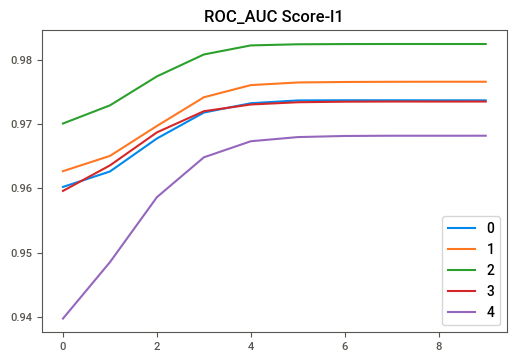

In [ ]:
pd.DataFrame(result.scores_[1.0][:,:,0].T).plot.line()
plt.title("ROC_AUC Score-l1")
plt.show()

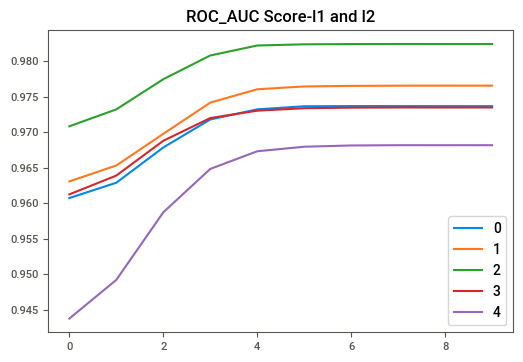

In [ ]:
pd.DataFrame(result.scores_[1.0][:,:,1].T).plot.line()
plt.title("ROC_AUC Score-l1 and l2")
plt.show()

## Model-02: Logistic Regression
L1 and L2 regularization with 11 folds

In [ ]:
# Logistic Regression with 11 folds
lrcv = LogisticRegressionCV(cv=11, 
                            random_state=0, 
                            max_iter=1000,
                            class_weight="balanced",
                            penalty="elasticnet", solver="saga", l1_ratios=[0.01, 0.001],
                            scoring='roc_auc')

In [ ]:
# train the model
result2 = lrcv.fit(X, y)

In [ ]:
result2.scores_[1.0].shape

(11, 10, 2)

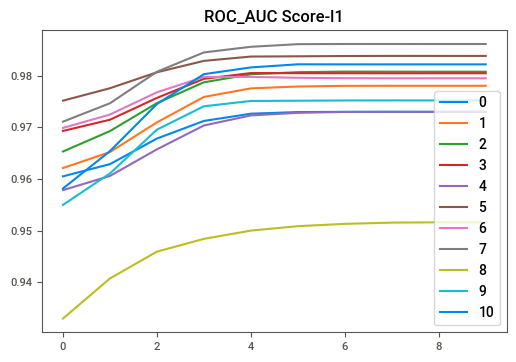

In [ ]:
pd.DataFrame(result2.scores_[1.0][:,:,0].T).plot.line()
plt.title("ROC_AUC Score-l1")
plt.show()

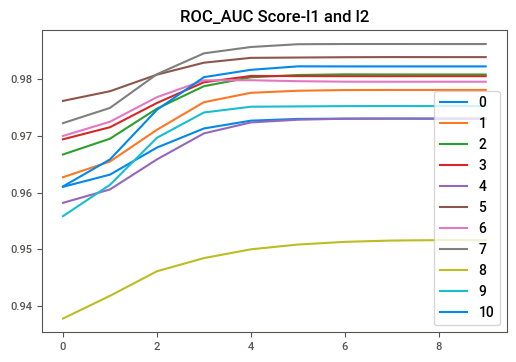

In [ ]:
pd.DataFrame(result2.scores_[1.0][:,:,1].T).plot.line()
plt.title("ROC_AUC Score-l1 and l2")
plt.show()

In [ ]:
# iteration taken at each cross-validation fold
result.n_iter_.max(), result2.n_iter_.max()

(562, 557)

In [ ]:
# highest AUC-scores
result.scores_[1.0].max(), result2.scores_[1.0].max()

(0.9824246853657055, 0.9861145184240224)

## Summary

- As we can see above the `recall` score is around `0.9` and above.
- Therefore we can conclude that the liner model is not performing well.
- We shall try bit complex models 

# Model Building (Decision Trees)

## Model-04: Decision Tree
 With default parameters

In [ ]:
# decision tree - 1
dt = DecisionTreeClassifier(random_state=0, class_weight='balanced')
result_dt1 = cross_val_score(dt, X, y, cv=5, scoring='roc_auc')

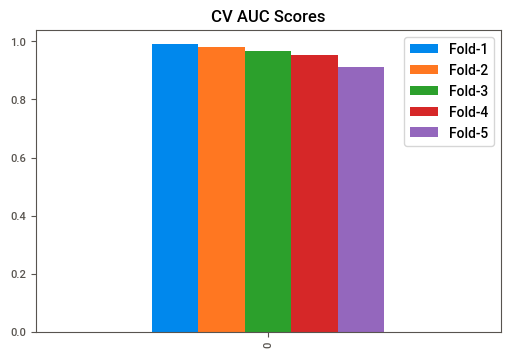

In [ ]:
# ROC-AUC Values
scores = result_dt1
pd.DataFrame(scores.reshape(1, len(scores)), columns=["Fold-%d"%(i+1) for i in range(len(scores))]).plot.bar()
plt.title("CV AUC Scores")
plt.show()

## Model-04: Decision Tree
 11 - Folds

In [ ]:
# decision tree - 1
dt2 = DecisionTreeClassifier(random_state=0, class_weight='balanced')
result_dt2 = cross_val_score(dt2, X, y, cv=11, scoring='roc_auc')

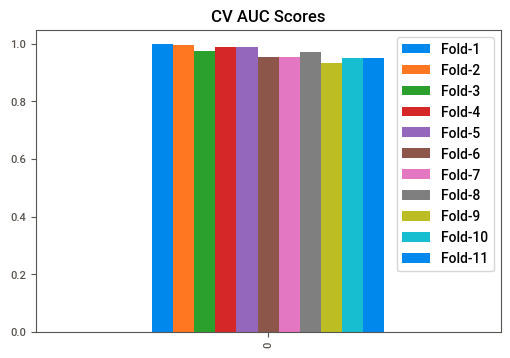

In [ ]:
# ROC-AUC Values
scores = result_dt2
pd.DataFrame(scores.reshape(1, len(scores)), columns=["Fold-%d"%(i+1) for i in range(len(scores))]).plot.bar()
plt.title("CV AUC Scores")
plt.show()

## Summary

- As we can see above the last experiment with 11 folds is giving us the best ROC_AUC score.

- Let us understand which model it is

In [ ]:
# highest AUC-scores
result.scores_[1.0].max(), result2.scores_[1.0].max(), result_dt1.max(), result_dt2.max()

(0.9824246853657055,
 0.9861145184240224,
 0.9899912626153904,
 0.9980306533093586)

- We can clearly see the last experiment with decision tree is giving us the best model so far w.r.t ROC_AUC score
- But this can be an indication of overfitting as well.
- Let us understand the facts below...

In [ ]:
# run  a plain decison tree and find tune the parameters
dt3 = DecisionTreeClassifier(random_state=0, class_weight='balanced')
result_dt3 = dt3.fit(X, y)

### Depth of the tree

In [ ]:
# depth of the tree
dt3.get_depth()

24

In [ ]:
# # plot the decision tree
# from sklearn.tree import plot_tree
# plt.figure(figsize=[400, 20])
# plot_tree(dt3)
# plt.show()

Output hidden; open in https://colab.research.google.com to view.

- As we can see above, this is a very complex model.
- Which is essentially remembering the entire trainig data.

## Grid Search

**Define grid search parameters**

## Hyperparameter Tuning

In [ ]:
X.shape

(5214, 30)

In [ ]:
# decision tree parameter grids
parameters = {'criterion':['gini', 'entropy'],
              'max_depth':[3, 5, 10, 15, 40],
              'min_samples_leaf' : [2, 5, 10, 15],
              'min_samples_split' : [2, 10, 25, 30],
              'max_features' : ['auto', 'log2'],
            }

# prepare grid search object
dt4 = DecisionTreeClassifier(random_state=0, class_weight='balanced')
gridcv_dt = GridSearchCV(dt4, parameters, cv=5, 
                        scoring = ['roc_auc', 'accuracy', 'recall', 'precision', 'neg_log_loss'], refit='roc_auc',
                        error_score='raise', verbose=2, return_train_score=True)

In [ ]:
# Perform the grid search
res_gridcv_dt = gridcv_dt.fit(X, y)
# save the model
dump(gridcv_dt, root % 'gridcv_dt.joblib')
dump(res_gridcv_dt, root % 'res_gridcv_dt.joblib')

Fitting 5 folds for each of 320 candidates, totalling 1600 fits
[CV] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=2; total time=   0.0s
[CV] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=2; total time=   0.0s
[CV] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=2; total time=   0.1s
[CV] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=2; total time=   0.1s
[CV] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=2; total time=   0.1s
[CV] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=10; total time=   0.1s
[CV] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=10; total time=   0.1s
[CV] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=10; total time=   0.

['/content/drive/MyDrive/TechGig_HPE_ML_2022/res_gridcv_dt.joblib']

In [ ]:
# load the model
gridcv_dt = load(root % 'gridcv_dt.joblib')
res_gridcv_dt = load(root % 'res_gridcv_dt.joblib')

### Search Summary

In [ ]:
# grid search result
cvdf = pd.DataFrame(gridcv_dt.cv_results_)
cvdf.head(2)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.025694      0.005391         0.039158        0.023727   
1       0.024806      0.003566         0.055551        0.019974   

  param_criterion param_max_depth param_max_features param_min_samples_leaf  \
0            gini               3               auto                      2   
1            gini               3               auto                      2   

  param_min_samples_split  \
0                       2   
1                      10   

                                                                                                          params  \
0   {'criterion': 'gini', 'max_depth': 3, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2}   
1  {'criterion': 'gini', 'max_depth': 3, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 10}   

   split0_test_roc_auc  split1_test_roc_auc  split2_test_roc_auc  \
0             0.952271             0.955796             0.967147   
1             0.952271             0.955796             0.967147   

   split3_test_roc_auc  split4_test_roc_auc  mean_test_roc_auc  \
0             0.931296             0.944109           0.950124   
1             0.931296             0.944109           0.950124   

   std_test_roc_auc  rank_test_roc_auc  split0_train_roc_auc  \
0          0.011977                223              0.950348   
1          0.011977                223              0.950348   

   split1_train_roc_auc  split2_train_roc_auc  split3_train_roc_auc  \
0              0.949103              0.945953              0.955352   
1              0.949103              0.945953              0.955352   

   split4_train_roc_auc  mean_train_roc_auc  std_train_roc_auc  \
0              0.940153            0.948182           0.005028   
1              0.940153            0.948182           0.005028   

   split0_test_accuracy  split1_test_accuracy  split2_test_accuracy  \
0              0.871524              0.868648              0.899329   
1              0.871524              0.868648              0.899329   

   split3_test_accuracy  split4_test_accuracy  mean_test_accuracy  \
0              0.873442              0.888676            0.880324   
1              0.873442              0.888676            0.880324   

   std_test_accuracy  rank_test_accuracy  split0_train_accuracy  \
0           0.011765                 257               0.885639   
1           0.011765                 257               0.885639   

   split1_train_accuracy  split2_train_accuracy  split3_train_accuracy  \
0               0.886358               0.878686               0.885159   
1               0.886358               0.878686               0.885159   

   split4_train_accuracy  mean_train_accuracy  std_train_accuracy  \
0               0.871764             0.881521              0.0056   
1               0.871764             0.881521              0.0056   

   split0_test_recall  split1_test_recall  split2_test_recall  \
0            0.829545            0.856061            0.878788   
1            0.829545            0.856061            0.878788   

   split3_test_recall  split4_test_recall  mean_test_recall  std_test_recall  \
0            0.863636            0.882353          0.862077         0.018907   
1            0.863636            0.882353          0.862077         0.018907   

   rank_test_recall  split0_train_recall  split1_train_recall  \
0               251             0.876362              0.86973   
1               251             0.876362              0.86973   

   split2_train_recall  split3_train_recall  split4_train_recall  \
0             0.864045             0.867835             0.838542   
1             0.864045             0.867835             0.838542   

   mean_train_recall  std_train_recall  split0_test_precision  \
0           0.863303          0.013008               0.908714   
1           0.863303          0.013008               0.908714   

   split1_test_precision  s

In [ ]:
# best model
gridcv_dt.best_estimator_

DecisionTreeClassifier(class_weight='balanced', max_depth=10,
                       max_features='auto', min_samples_leaf=5,
                       min_samples_split=30, random_state=0)

In [ ]:
# # plot the decision tree
# from sklearn.tree import plot_tree
# plt.figure(figsize=[400, 25])
# plot_tree(gridcv_dt.best_estimator_)
# plt.show()

In [ ]:
# best score
gridcv_dt.best_score_

0.971056927810557

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


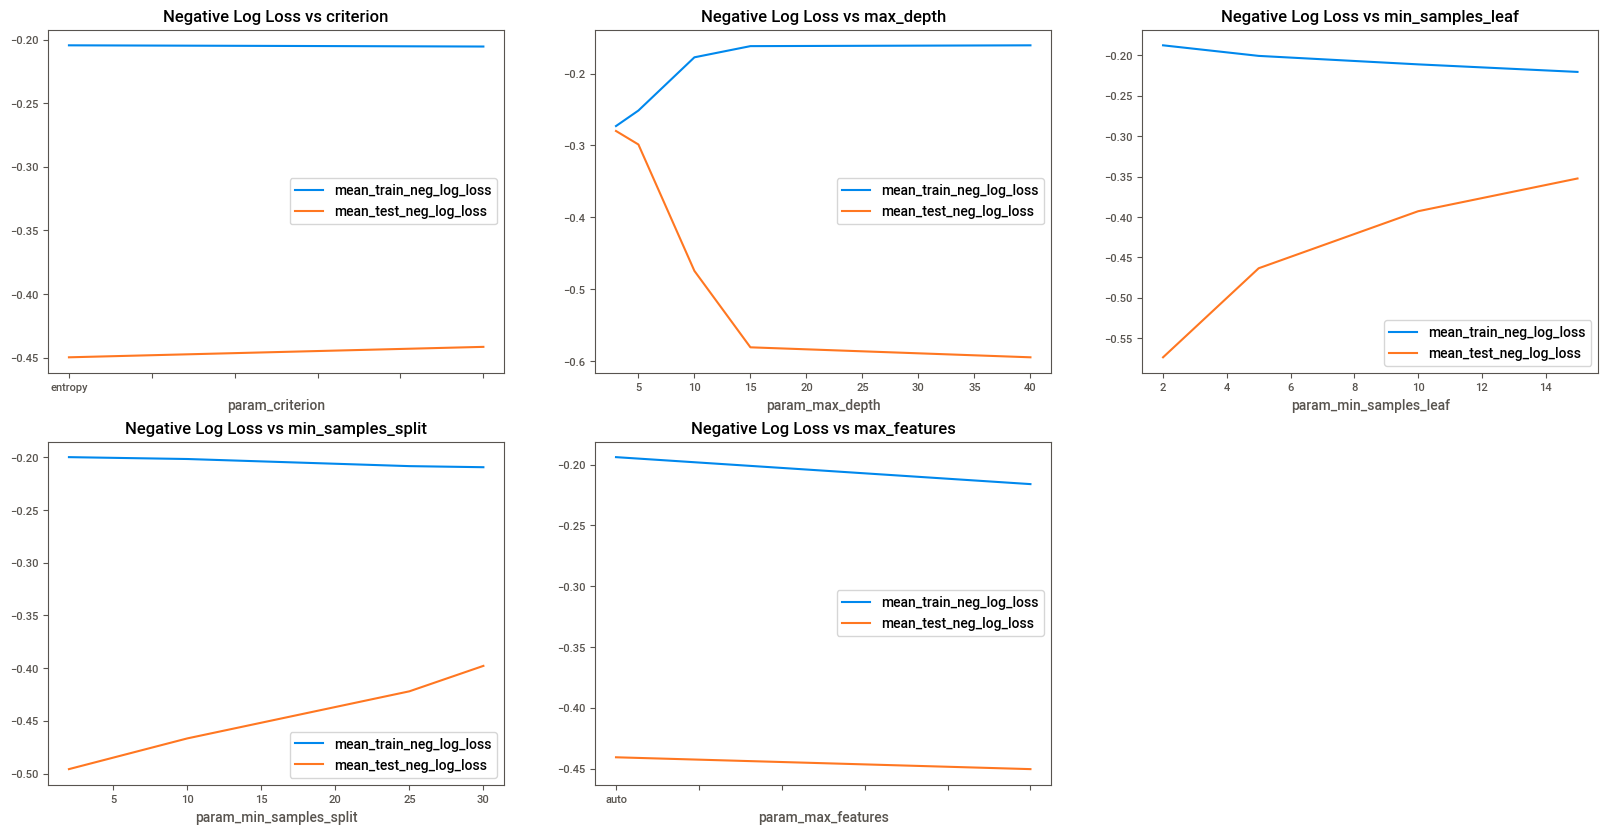

In [ ]:
# grid search performance plots
features = parameters.keys()
plt.figure(figsize=(20, 10))
for i, f in enumerate(features):
    ax=plt.subplot(2,3,i+1)
    cvdf.groupby('param_%s'%f)['mean_train_roc_auc', 'mean_test_roc_auc'].mean().plot(ax=ax)
    ax.set_title("AUC vs %s"%f)
plt.show()
features = parameters.keys()
plt.figure(figsize=(20, 10))
for i, f in enumerate(features):
    ax=plt.subplot(2,3,i+1)
    cvdf.groupby('param_%s'%f)['mean_train_neg_log_loss', 'mean_test_neg_log_loss'].mean().plot(ax=ax)
    ax.set_title("Negative Log Loss vs %s"%f)
plt.show()

## Finetuning - Grid Search CV

In [ ]:
# decision tree parameter grids
parameters = {
              'max_depth':range(30, 50),
              'min_samples_leaf' : range(2, 5),
              'min_samples_split' : range(2, 5)
              }

# prepare grid search object
dt5 = DecisionTreeClassifier(random_state=0, 
                             class_weight='balanced',
                             criterion='entropy',
                             max_features='log2',
                             

                             )
gridcv_dt2 = GridSearchCV(dt5, parameters, cv=5, 
                        scoring = ['roc_auc', 'accuracy', 'recall', 'precision', 'neg_log_loss'], 
                        refit='roc_auc',
                        error_score='raise', verbose=2, return_train_score=True)

In [ ]:
# Perform the grid search
res_gridcv_dt2 = gridcv_dt2.fit(X, y)
dump(gridcv_dt2, root % 'gridcv_dt2.joblib')
dump(res_gridcv_dt2, root % 'res_gridcv_dt2.joblib')

Fitting 5 folds for each of 180 candidates, totalling 900 fits
[CV] END max_depth=30, min_samples_leaf=2, min_samples_split=2; total time=   0.0s
[CV] END max_depth=30, min_samples_leaf=2, min_samples_split=2; total time=   0.0s
[CV] END max_depth=30, min_samples_leaf=2, min_samples_split=2; total time=   0.0s
[CV] END max_depth=30, min_samples_leaf=2, min_samples_split=2; total time=   0.0s
[CV] END max_depth=30, min_samples_leaf=2, min_samples_split=2; total time=   0.0s
[CV] END max_depth=30, min_samples_leaf=2, min_samples_split=3; total time=   0.0s
[CV] END max_depth=30, min_samples_leaf=2, min_samples_split=3; total time=   0.0s
[CV] END max_depth=30, min_samples_leaf=2, min_samples_split=3; total time=   0.0s
[CV] END max_depth=30, min_samples_leaf=2, min_samples_split=3; total time=   0.0s
[CV] END max_depth=30, min_samples_leaf=2, min_samples_split=3; total time=   0.0s
[CV] END max_depth=30, min_samples_leaf=2, min_samples_split=4; total time=   0.0s
[CV] END max_depth=30, m

['/content/drive/MyDrive/TechGig_HPE_ML_2022/res_gridcv_dt2.joblib']

In [ ]:
# load the model
# gridcv_dt2 = load(root % 'gridcv_dt2.joblib')
# res_gridcv_dt2 = load(root % 'res_gridcv_dt2.joblib')

In [ ]:
# grid search result
cvdf = pd.DataFrame(gridcv_dt2.cv_results_)
cvdf.head(2)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.006825      0.000391         0.009282        0.000787   
1       0.008519      0.001932         0.009558        0.000921   

  param_max_depth param_min_samples_leaf param_min_samples_split  \
0              30                      2                       2   
1              30                      2                       3   

                                                             params  \
0  {'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 2}   
1  {'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 3}   

   split0_test_roc_auc  split1_test_roc_auc  split2_test_roc_auc  \
0               0.9547             0.958085             0.968075   
1               0.9547             0.958085             0.968075   

   split3_test_roc_auc  split4_test_roc_auc  mean_test_roc_auc  \
0             0.939995             0.926245            0.94942   
1             0.939995             0.926245            0.94942   

   std_test_roc_auc  rank_test_roc_auc  split0_train_roc_auc  \
0          0.014676                121              0.993067   
1          0.014676                121              0.993067   

   split1_train_roc_auc  split2_train_roc_auc  split3_train_roc_auc  \
0              0.993844              0.993147               0.99318   
1              0.993844              0.993147               0.99318   

   split4_train_roc_auc  mean_train_roc_auc  std_train_roc_auc  \
0              0.993655            0.993379           0.000311   
1              0.993655            0.993379           0.000311   

   split0_test_accuracy  split1_test_accuracy  split2_test_accuracy  \
0              0.902205              0.923298              0.924257   
1              0.902205              0.923298              0.924257   

   split3_test_accuracy  split4_test_accuracy  mean_test_accuracy  \
0              0.910834              0.888676            0.909854   
1              0.910834              0.888676            0.909854   

   std_test_accuracy  rank_test_accuracy  split0_train_accuracy  \
0           0.013388                   1               0.949652   
1           0.013388                   1               0.949652   

   split1_train_accuracy  split2_train_accuracy  split3_train_accuracy  \
0               0.950372               0.946296               0.948693   
1               0.950372               0.946296               0.948693   

   split4_train_accuracy  mean_train_accuracy  std_train_accuracy  \
0               0.948466             0.948696            0.001381   
1               0.948466             0.948696            0.001381   

   split0_test_recall  split1_test_recall  split2_test_recall  \
0            0.861742            0.895833            0.897727   
1            0.861742            0.895833            0.897727   

   split3_test_recall  split4_test_recall  mean_test_recall  std_test_recall  \
0            0.892045             0.87666          0.884802         0.013706   
1            0.892045             0.87666          0.884802         0.013706   

   rank_test_recall  split0_train_recall  split1_train_recall  \
0                61             0.926101             0.931786   
1                61             0.926101             0.931786   

   split2_train_recall  split3_train_recall  split4_train_recall  \
0             0.927996             0.928944             0.931345   
1             0.927996             0.928944             0.931345   

   mean_train_recall  std_train_recall  split0_test_precision  \
0           0.929234          0.002116               0.940083   
1           0.929234          0.002116               0.940083   

   split1_test_precision  split2_test_precision  split3_test_precision  \
0               0.949799                 0.9499               0.928994   
1               0.949799                 0.9499               0.928994   

   split4_test_precision  mean_test_precision  std_test_prec

In [ ]:
# best model
gridcv_dt2.best_estimator_

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=30, max_features='log2', min_samples_leaf=4,
                       random_state=0)

In [ ]:
# # plot the decision tree
# from sklearn.tree import plot_tree
# plt.figure(figsize=[400, 25])
# plot_tree(gridcv_dt2.best_estimator_)
# plt.show()

In [ ]:
# best score
gridcv_dt.best_score_, gridcv_dt2.best_score_

(0.971056927810557, 0.9559734759860726)

- Performance improved a bit

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


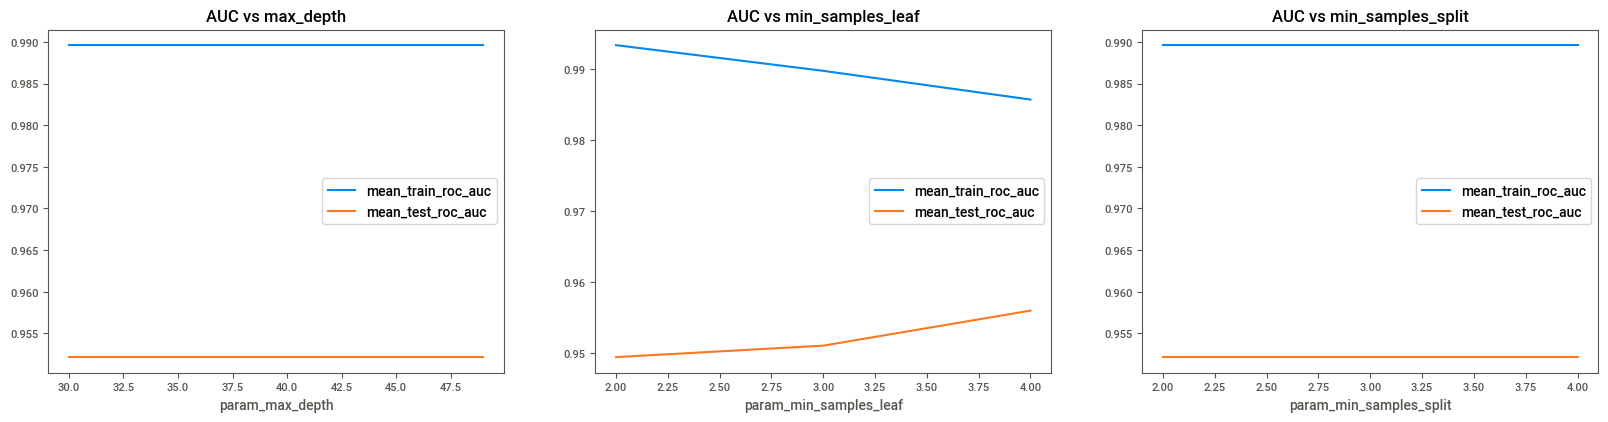

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  del sys.path[0]


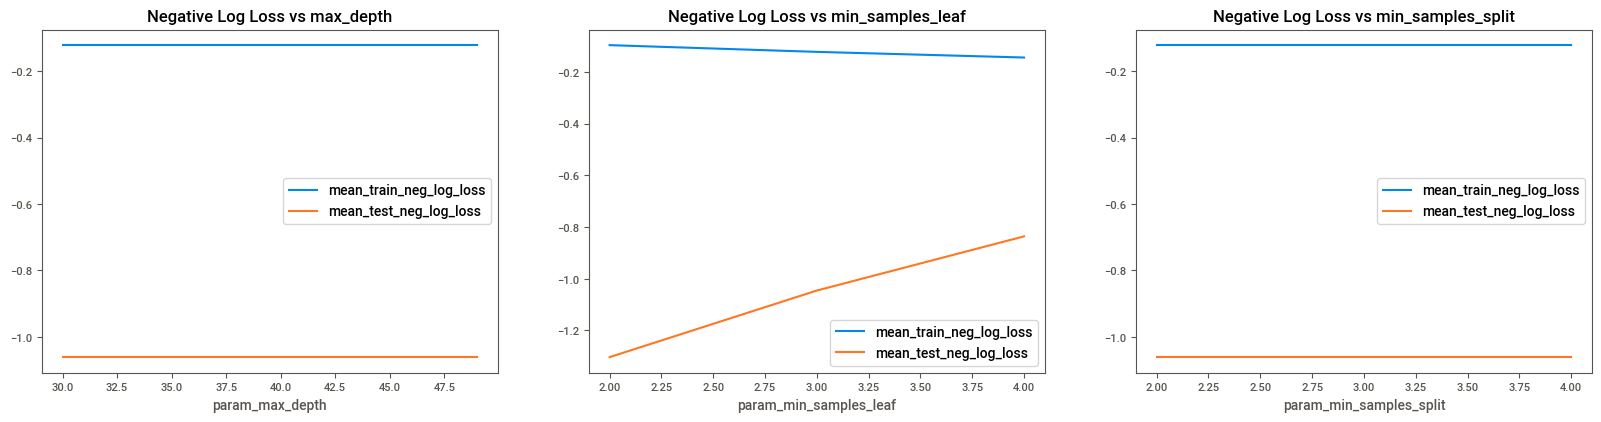

In [ ]:
# grid search performance plots
features = parameters.keys()
plt.figure(figsize=(20, 10))
for i, f in enumerate(features):
    ax=plt.subplot(2,3,i+1)
    cvdf.groupby('param_%s'%f)['mean_train_roc_auc', 'mean_test_roc_auc'].mean().plot(ax=ax)
    ax.set_title("AUC vs %s"%f)
plt.show()
features = parameters.keys()
plt.figure(figsize=(20, 10))
for i, f in enumerate(features):
    ax=plt.subplot(2,3,i+1)
    cvdf.groupby('param_%s'%f)['mean_train_neg_log_loss', 'mean_test_neg_log_loss'].mean().plot(ax=ax)
    ax.set_title("Negative Log Loss vs %s"%f)
plt.show()

1. Performance is good when `"min_samples_leaf"` is `4`
1. Performance is best when `"max_depth"` is `10`
1. Performance is best when `"min_samples_split"` is `25`


In [24]:
# prepare grid search object
dt6 =  DecisionTreeClassifier(random_state=0, 
                             class_weight='balanced',
                             criterion='entropy',
                             max_features='log2',
                             min_samples_split = 2,
                             max_depth=10,
                              min_samples_leaf=3,
                             )


In [25]:
# fit and save the model and results
res_dt6 = dt6.fit(X, y)
# save the model
dump(dt6, root % 'dt6.joblib')
dump(res_dt6, root % 'res_dt6.joblib')

['./res_dt6.joblib']

In [ ]:
# load the model
dt6 = load(root % 'dt6.joblib')
res_dt6 = load(root % 'res_dt6.joblib')

## Feature Importance

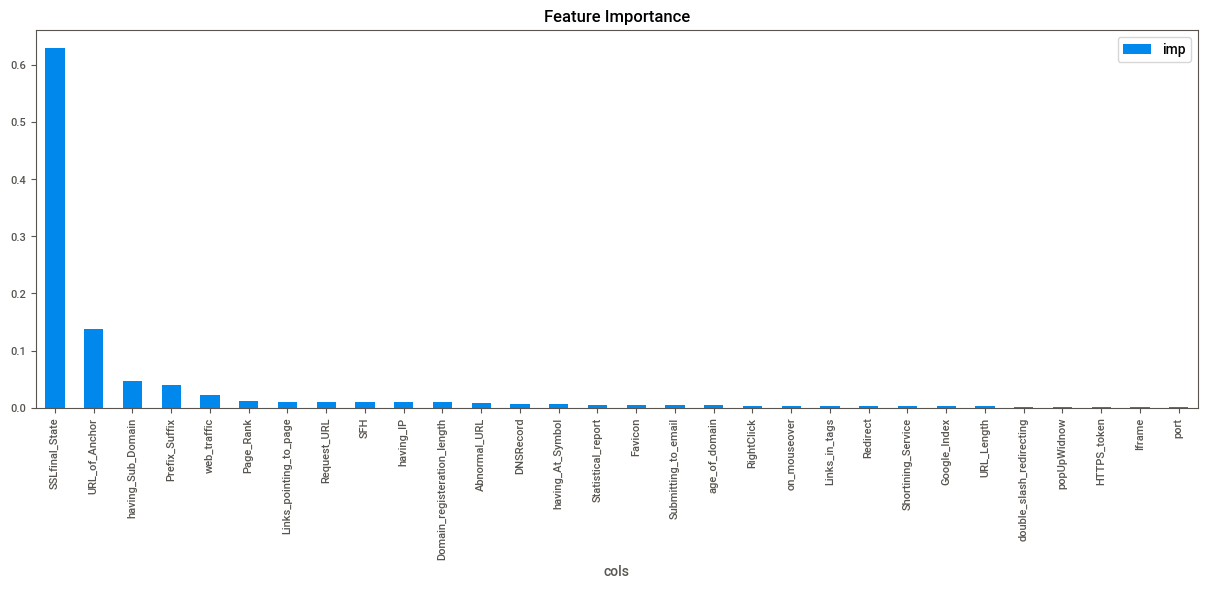

In [26]:
# feature importance
fdf = pd.DataFrame(dict(imp=dt6.feature_importances_, cols=X.columns))\
            .sort_values(by="imp", ascending=False)
fdf.plot.bar(x='cols', title="Feature Importance", figsize=[15, 5])
plt.show()

In [27]:
# top 5 features
fdf.head()

imp               cols
7   0.629824     SSLfinal_State
13  0.137447      URL_of_Anchor
6   0.046443  having_Sub_Domain
5   0.040272      Prefix_Suffix
25  0.021512        web_traffic

C:\Users\dndlssardar\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


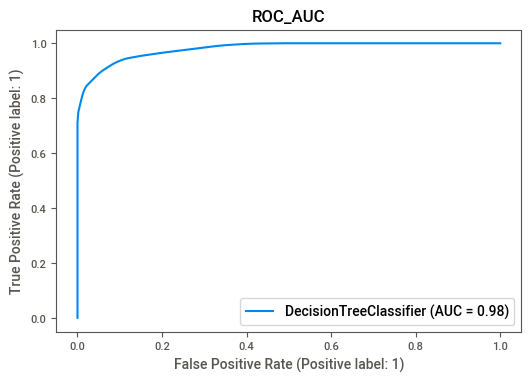

In [28]:
# ROC - AUC
from sklearn import metrics 

metrics.plot_roc_curve(dt6, X, y)
plt.title("ROC_AUC")
plt.show()

## Finding the probability cutoff

In [29]:
# calculate probability values
y_train_proba =pd.Series(dt6.predict_proba(X)[:, 1])

# prepare a dataframe
y_train_final = pd.DataFrame(columns=['phishing', 'proba'])

y_train_final['phishing'] = np.array(y)
y_train_final['proba'] = y_train_proba
# calculate prediction for different probability values
cutoff_range= np.arange(0, 1.001, 0.001)
for i in cutoff_range:
    y_train_final[f"{round(i,2)}"] = y_train_proba.apply(lambda x: 1 if x >= i else 0)
y_train_final.head()


C:\Users\DNDLSS~1\AppData\Local\Temp/ipykernel_15836/906947414.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  y_train_final[f"{round(i,2)}"] = y_train_proba.apply(lambda x: 1 if x >= i else 0)


phishing     proba  0.0  0.01  0.02  0.03  0.04  0.05  0.06  0.07  0.08  \
0         1  1.000000    1     1     1     1     1     1     1     1     1   
1         1  0.183789    1     1     1     1     1     1     1     1     1   
2         1  0.865786    1     1     1     1     1     1     1     1     1   
3         1  0.865786    1     1     1     1     1     1     1     1     1   
4         0  0.196101    1     1     1     1     1     1     1     1     1   

   0.09  0.1  0.11  0.12  0.13  0.14  0.15  0.16  0.17  0.18  0.19  0.2  0.21  \
0     1    1     1     1     1     1     1     1     1     1     1    1     1   
1     1    1     1     1     1     1     1     1     1     0     0    0     0   
2     1    1     1     1     1     1     1     1     1     1     1    1     1   
3     1    1     1     1     1     1     1     1     1     1     1    1     1   
4     1    1     1     1     1     1     1     1     1     1     1    0     0   

   0.22  0.23  0.24  0.25  0.26  0.27  0.28  0.29  0.3  0.31  0.32  0.33  \
0     1     1     1     1     1     1     1     1    1     1     1     1   
1     0     0     0     0     0     0     0     0    0     0     0     0   
2     1     1     1     1     1     1     1     1    1     1     1     1   
3     1     1     1     1     1     1     1     1    1     1     1     1   
4     0     0     0     0     0     0     0     0    0     0     0     0   

   0.34  0.35  0.36  0.37  0.38  0.39  0.4  0.41  0.42  0.43  0.44  0.45  \
0     1     1     1     1     1     1    1     1     1     1     1     1   
1     0     0     0     0     0     0    0     0     0     0     0     0   
2     1     1     1     1     1     1    1     1     1     1     1     1   
3     1     1     1     1     1     1    1     1     1     1     1     1   
4     0     0     0     0     0     0    0     0     0     0     0     0   

   0.46  0.47  0.48  0.49  0.5  0.51  0.52  0.53  0.54  0.55  0.56  0.57  \
0     1     1     1     1    1     1     1     1     1     1     1     1   
1     0     0     0     0    0     0     0     0     0     0     0     0   
2     1     1     1     1    1     1     1     1     1     1     1     1   
3     1     1     1     1    1     1     1     1     1     1     1     1   
4     0     0     0     0    0     0     0     0     0     0     0     0   

   0.58  0.59  0.6  0.61  0.62  0.63  0.64  0.65  0.66  0.67  0.68  0.69  0.7  \
0     1     1    1     1     1     1     1     1     1     1     1     1    1   
1     0     0    0     0     0     0     0     0     0     0     0     0    0   
2     1     1    1     1     1     1     1     1     1     1     1     1    1   
3     1     1    1     1     1     1     1     1     1     1     1     1    1   
4     0     0    0     0     0     0     0     0     0     0     0     0    0   

   0.71  0.72  0.73  0.74  0.75  0.76  0.77  0.78  0.79  0.8  0.81  0.82  \
0     1     1     1     1     1     1     1     1     1    1     1     1   
1     0     0     0     0     0     0     0     0     0    0     0     0   
2     1     1     1     1     1     1     1     1     1    1     1     1   
3     1     1     1     1     1     1     1     1     1    1     1     1   
4     0     0     0     0     0     0     0     0     0    0     0     0   

   0.83  0.84  0.85  0.86  0.87  0.88  0.89  0.9  0.91  0.92  0.93  0.94  \
0     1     1     1     1     1     1     1    1     1     1     1     1   
1     0     0     0     0     0     0     0    0     0     0     0     0   
2     1     1     1     1     0     0     0    0     0     0     0     0   
3     1     1     1     1     0     0     0    0     0     0     0     0   
4     0     0     0     0     0     0     0    0     0     0     0     0   

   0.95  0.96  0.97  0.98  0.99  1.0  
0     1     1     1     1     1    1  
1     0     0     0     0     0    0  
2     0     0     0     0     0    0  
3     0     0     0     0     0    0  
4     0     0     0     0     0    0

In [30]:
# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['cutoff', 'accuracy', 'sensi', 'speci','false negative rate', 'false positive rate'])
for i in cutoff_range:
    cm1 = metrics.confusion_matrix(y_train_final["phishing"], y_train_final[f"{round(i,2)}"] )
    total1=sum(sum(cm1))
    # metrics
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    false_negative_rate = 1-sensi
    false_positive_rate = 1-speci
    # update dataframe
    cutoff_df.loc[i] =[i, accuracy, sensi, speci, false_negative_rate, false_positive_rate]
cutoff_df.sample(10)

cutoff  accuracy     sensi     speci  false negative rate  \
0.879   0.879  0.872075  0.749147  0.998058             0.250853   
0.698   0.698  0.910242  0.842743  0.979417             0.157257   
0.966   0.966  0.853663  0.710875  1.000000             0.289125   
0.366   0.366  0.917722  0.937855  0.897087             0.062145   
0.096   0.096  0.821059  0.993558  0.644272             0.006442   
0.730   0.730  0.909091  0.838954  0.980971             0.161046   
0.267   0.267  0.914461  0.944297  0.883883             0.055703   
0.646   0.646  0.911009  0.845775  0.977864             0.154225   
0.105   0.105  0.821059  0.993558  0.644272             0.006442   
0.349   0.349  0.916763  0.940508  0.892427             0.059492   

       false positive rate  
0.879             0.001942  
0.698             0.020583  
0.966             0.000000  
0.366             0.102913  
0.096             0.355728  
0.730             0.019029  
0.267             0.116117  
0.646             0.022136  
0.105             0.355728  
0.349             0.107573

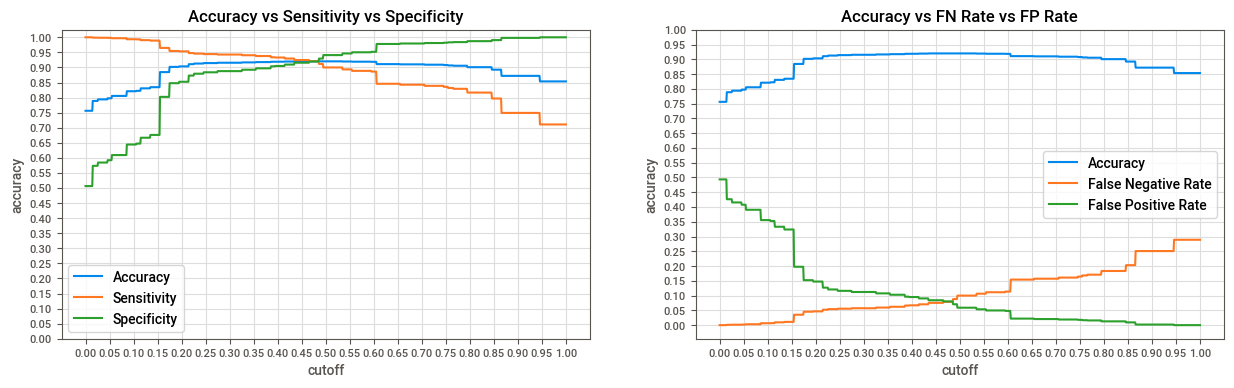

In [31]:
# metric comparison polt
plt.figure(figsize=[15, 9])
ax = plt.subplot(2,2,1)
ax.set_title("Accuracy vs Sensitivity vs Specificity")
sns.lineplot(data=cutoff_df, x="cutoff", y="accuracy", label="Accuracy")
sns.lineplot(data=cutoff_df, x="cutoff", y="sensi", label="Sensitivity")
sns.lineplot(data=cutoff_df, x="cutoff", y="speci", label="Specificity")
ax.set_xticks(np.arange(0, 1.05, 0.05))
ax.set_yticks(np.arange(0, 1.05, 0.05))
ax.grid(visible=True, color="#dddddd")
ax = plt.subplot(2,2,2)
ax.set_title("Accuracy vs FN Rate vs FP Rate")
sns.lineplot(data=cutoff_df, x="cutoff", y="accuracy", label="Accuracy")
sns.lineplot(data=cutoff_df, x="cutoff", y="false negative rate", label="False Negative Rate")
sns.lineplot(data=cutoff_df, x="cutoff", y="false positive rate", label="False Positive Rate")
ax.grid(visible=True, color="#dddddd")
ax.set_xticks(np.arange(0, 1.05, 0.05))
ax.set_yticks(np.arange(0, 1.05, 0.05))
plt.show()

### Optimal `probability cutoff` for prediction

In [32]:
# optimal cutoff finding
closest = np.argmin(np.array(cutoff_df["false positive rate"] - cutoff_df["false negative rate"])**2)
optimal = pd.DataFrame(cutoff_df.iloc[closest]).T
optimal

cutoff  accuracy     sensi     speci  false negative rate  \
0.466   0.466  0.920407  0.921182  0.919612             0.078818   

       false positive rate  
0.466             0.080388

In [33]:
# optimal values
optimal = round(optimal, 3)
print("Optimal Probability cutoff: ", optimal['cutoff'].values)
print("Accuracy at optimal cutoff: ", optimal['accuracy'].values)
print("Sensitivity at optimal cutoff: ", optimal['sensi'].values)
print("Specificity at optimal cutoff: ", optimal['speci'].values)
print("FNR at optimal cutoff: ", optimal['false negative rate'].values)
print("FPR at optimal cutoff: ", optimal['false positive rate'].values)

Optimal Probability cutoff:  [0.466]
Accuracy at optimal cutoff:  [0.92]
Sensitivity at optimal cutoff:  [0.921]
Specificity at optimal cutoff:  [0.92]
FNR at optimal cutoff:  [0.079]
FPR at optimal cutoff:  [0.08]


## Analytics Decision on `cutoff`

- As we want to correctly predict the `phising` site, we should keep the **`FNR`** to **as low as possible**.
- While considering the **Accuracy** in mind

In [34]:
# choose a cutoff = 0.25
my_options = pd.DataFrame(cutoff_df.loc[0.25]).T
my_options

cutoff  accuracy     sensi     speci  false negative rate  \
0.25    0.25  0.914461  0.944297  0.883883             0.055703   

      false positive rate  
0.25             0.116117

In [35]:
# My values
my_options = round(my_options, 3)
print("Our Probability cutoff: ", my_options['cutoff'].values)
print("Accuracy at our cutoff: ", my_options['accuracy'].values)
print("Sensitivity at our cutoff: ", my_options['sensi'].values)
print("Specificity at our cutoff: ", my_options['speci'].values)
print("FNR at our cutoff: ", my_options['false negative rate'].values)
print("FPR at our cutoff: ", my_options['false positive rate'].values)

Our Probability cutoff:  [0.25]
Accuracy at our cutoff:  [0.914]
Sensitivity at our cutoff:  [0.944]
Specificity at our cutoff:  [0.884]
FNR at our cutoff:  [0.056]
FPR at our cutoff:  [0.116]


# Decision tree with 5 folds

In [ ]:
# decision tree parameter grids
parameters = {'criterion':['gini', 'entropy'],
              'max_depth':[3, 4, 5, 6, 10, 15],
              'min_samples_leaf' : [1, 2, 5, 10],
              'min_samples_split' : [10, 20, 30],
              'max_features' : ['auto', 'log2'],
            }

# prepare grid search object
dt7 = DecisionTreeClassifier(random_state=0, class_weight='balanced')
gridcv_dt7 = GridSearchCV(dt7, parameters, cv=5, 
                        scoring = ['roc_auc', 'accuracy', 'recall', 'precision'], refit='roc_auc',
                        error_score='raise', verbose=3, return_train_score=True)

In [ ]:
# Perform the grid search
res_gridcv_dt7 = gridcv_dt7.fit(X, y)
# save the model
dump(gridcv_dt7, root % 'gridcv_dt7.joblib')
dump(res_gridcv_dt7, root % 'res_gridcv_dt7.joblib')

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
[CV 1/5] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=10; accuracy: (train=0.907, test=0.894) precision: (train=0.889, test=0.892) recall: (train=0.901, test=0.862) roc_auc: (train=0.953, test=0.923) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=10; accuracy: (train=0.905, test=0.902) precision: (train=0.889, test=0.890) recall: (train=0.895, test=0.885) roc_auc: (train=0.952, test=0.931) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=10; accuracy: (train=0.902, test=0.913) precision: (train=0.888, test=0.896) recall: (train=0.889, test=0.908) roc_auc: (train=0.946, test=0.956) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=10; accuracy: (train=0.892, test=0.874) preci

['/content/drive/MyDrive/TechGig_HPE_ML_2022/res_gridcv_dt7.joblib']

In [ ]:
# load the model
gridcv_dt7 = load(root % 'gridcv_dt7.joblib')
res_gridcv_dt7 = load(root % 'res_gridcv_dt7.joblib')

### Search Summary

In [ ]:
# grid search result
cvdf = pd.DataFrame(gridcv_dt7.cv_results_)
cvdf.head(2)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.008535      0.003250         0.009515        0.001051   
1       0.007430      0.000573         0.008975        0.000423   

  param_criterion param_max_depth param_max_features param_min_samples_leaf  \
0            gini               3               auto                      1   
1            gini               3               auto                      1   

  param_min_samples_split  \
0                      10   
1                      20   

                                                                                                          params  \
0  {'criterion': 'gini', 'max_depth': 3, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 10}   
1  {'criterion': 'gini', 'max_depth': 3, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 20}   

   split0_test_roc_auc  split1_test_roc_auc  split2_test_roc_auc  \
0             0.922663             0.931298             0.955835   
1             0.922663             0.931298             0.955835   

   split3_test_roc_auc  split4_test_roc_auc  mean_test_roc_auc  \
0             0.938304             0.946739           0.938968   
1             0.938304             0.946739           0.938968   

   std_test_roc_auc  rank_test_roc_auc  split0_train_roc_auc  \
0          0.011576                229              0.953438   
1          0.011576                229              0.953438   

   split1_train_roc_auc  split2_train_roc_auc  split3_train_roc_auc  \
0              0.951833               0.94578              0.947571   
1              0.951833               0.94578              0.947571   

   split4_train_roc_auc  mean_train_roc_auc  std_train_roc_auc  \
0              0.944588            0.948642           0.003434   
1              0.944588            0.948642           0.003434   

   split0_test_accuracy  split1_test_accuracy  split2_test_accuracy  \
0              0.893914              0.901731              0.913456   
1              0.893914              0.901731              0.913456   

   split3_test_accuracy  split4_test_accuracy  mean_test_accuracy  \
0              0.873814              0.896147            0.895812   
1              0.873814              0.896147            0.895812   

   std_test_accuracy  rank_test_accuracy  split0_train_accuracy  \
0           0.012915                 216               0.907175   
1           0.012915                 216               0.907175   

   split1_train_accuracy  split2_train_accuracy  split3_train_accuracy  \
0               0.905221               0.902289                0.89182   
1               0.905221               0.902289                0.89182   

   split4_train_accuracy  mean_train_accuracy  std_train_accuracy  \
0               0.886237             0.898548            0.008121   
1               0.886237             0.898548            0.008121   

   split0_test_recall  split1_test_recall  split2_test_recall  \
0             0.86242            0.885204            0.908163   
1             0.86242            0.885204            0.908163   

   split3_test_recall  split4_test_recall  mean_test_recall  std_test_recall  \
0            0.831633            0.877551          0.872994         0.025414   
1            0.831633            0.877551          0.872994         0.025414   

   rank_test_recall  split0_train_recall  split1_train_recall  \
0               208              0.90051             0.894804   
1               208              0.90051             0.894804   

   split2_train_recall  split3_train_recall  split4_train_recall  \
0             0.889066             0.857826              0.84635   
1             0.889066             0.857826              0.84635   

   mean_train_recall  std_train_recall  split0_test_precision  \
0           0.877711           0.02154               0.891963   
1           0.877711           0.02154               0.891963   

   split1_test_precision  s

In [ ]:
# best model
gridcv_dt7.best_estimator_

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=15, max_features='log2', min_samples_leaf=2,
                       min_samples_split=30, random_state=0)

In [ ]:
# best score
gridcv_dt7.best_score_

0.9771859468813583

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  i

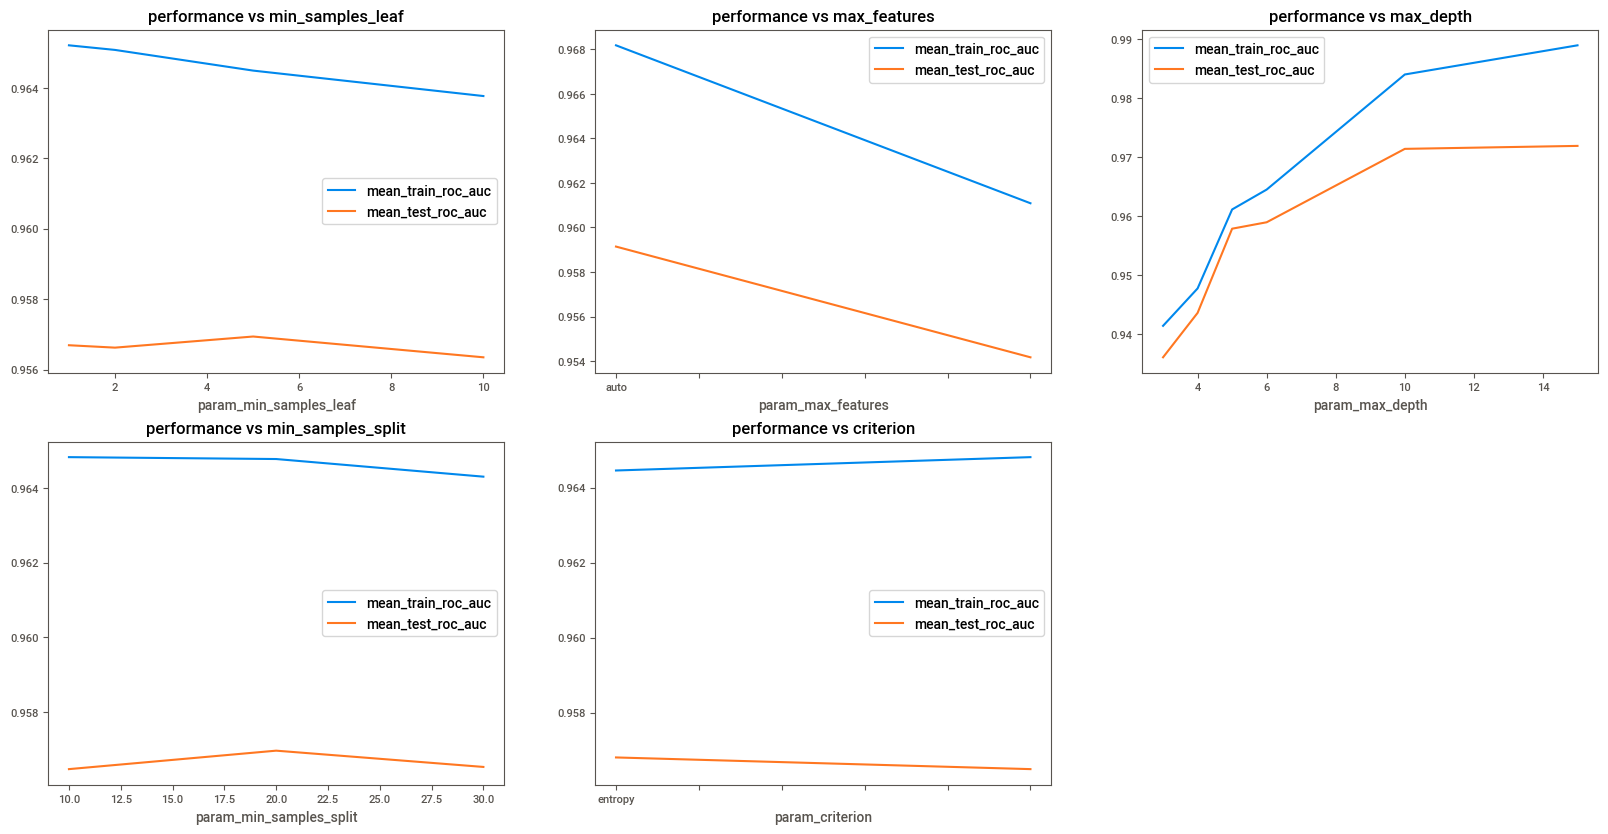

In [ ]:
# grid search performance plots
features = ["min_samples_leaf", "max_features", "max_depth", "min_samples_split",
            "criterion"]
plt.figure(figsize=(20, 10))
for i, f in enumerate(features):
    ax=plt.subplot(2,3,i+1)
    cvdf.groupby('param_%s'%f)['mean_train_roc_auc', 'mean_test_roc_auc'].mean().plot(ax=ax)
    ax.set_title("performance vs %s"%f)
plt.show()

## fine tune decision tree cv=5

In [ ]:
# decision tree parameter grids
parameters = {
              'max_depth': range(2, 30),
              'min_samples_split' : range(2, 100),
              'max_features':['auto', 'log2']
            }

# prepare grid search object
# prepare grid search object
dt8 = DecisionTreeClassifier(random_state=0, 
                            class_weight='balanced',
                            criterion='entropy',
                            min_samples_leaf=2)

gridcv_dt8 = RandomizedSearchCV(dt8, param_distributions=parameters, cv=5, 
                                n_iter=200,
                        scoring = ['roc_auc', 'accuracy', 'recall', 'precision'], refit='roc_auc',
                        error_score='raise', verbose=2, return_train_score=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  del sys.path[0]


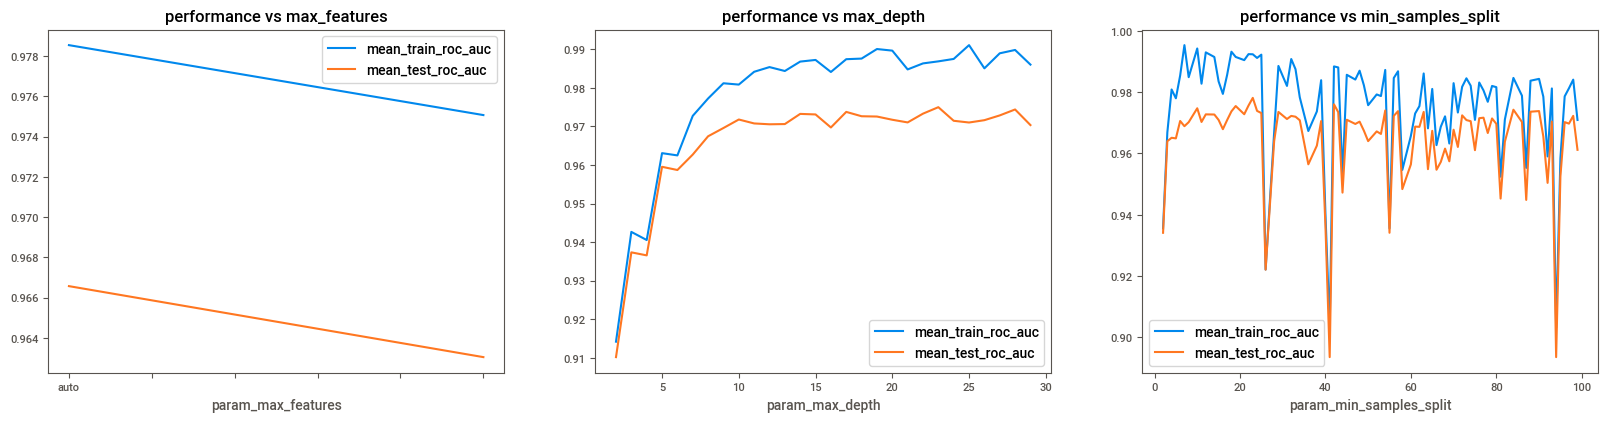

In [ ]:
# Perform the grid search
res_gridcv_dt8 = gridcv_dt8.fit(X, y)
# save the model
dump(gridcv_dt8, root % 'gridcv_dt8.joblib')
dump(res_gridcv_dt8, root % 'res_gridcv_dt8.joblib')
# grid search result
cvdf = pd.DataFrame(gridcv_dt8.cv_results_)
# grid search performance plots
features = ["max_features", "max_depth", "min_samples_split"]
plt.figure(figsize=(20, 10))
for i, f in enumerate(features):
    ax=plt.subplot(2,3,i+1)
    cvdf.groupby('param_%s'%f)['mean_train_roc_auc', 'mean_test_roc_auc'].mean().plot(ax=ax)
    ax.set_title("performance vs %s"%f)
plt.show()

In [ ]:
# best model
gridcv_dt8.best_estimator_

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=15, max_features='auto', min_samples_leaf=2,
                       min_samples_split=42, random_state=0)

In [ ]:
# prepare grid search object
dt8 = DecisionTreeClassifier(random_state=0, 
                            class_weight='balanced',
                            criterion='entropy',
                            max_features='log2',
                            min_samples_leaf=2,
                            max_depth=25,
                            min_samples_split=42)


In [ ]:
# fit and save the model and results
res_dt8 = dt8.fit(X, y)
# save the model
dump(dt8, root % 'dt8.joblib')
dump(res_dt8, root % 'res_dt8.joblib')

['/content/drive/MyDrive/TechGig_HPE_ML_2022/res_dt8.joblib']

# Random Forest with 5 folds

In [ ]:
# decision tree parameter grids
parameters = {'criterion':['gini', 'entropy'],
              'max_depth':[3, 4, 5, 6, 10, 15],
              'min_samples_leaf' : [1, 2, 5, 10],
              'min_samples_split' : [10, 20, 30],
              'max_features' : ['auto', 'log2'],
            }

# prepare grid search object
rf1 = RandomForestClassifier(random_state=0, class_weight='balanced')
gridcv_rf1 = GridSearchCV(rf1, parameters, cv=5, 
                        scoring = ['roc_auc', 'accuracy', 'recall', 'precision'], refit='roc_auc',
                        error_score='raise', verbose=2, return_train_score=True)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
[CV] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=10; total time=   0.7s
[CV] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=10; total time=   0.7s
[CV] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=10; total time=   0.7s
[CV] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=10; total time=   0.7s
[CV] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=10; total time=   0.8s
[CV] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=20; total time=   0.5s
[CV] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=20; total time=   0.4s
[CV] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=20; total time=

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated

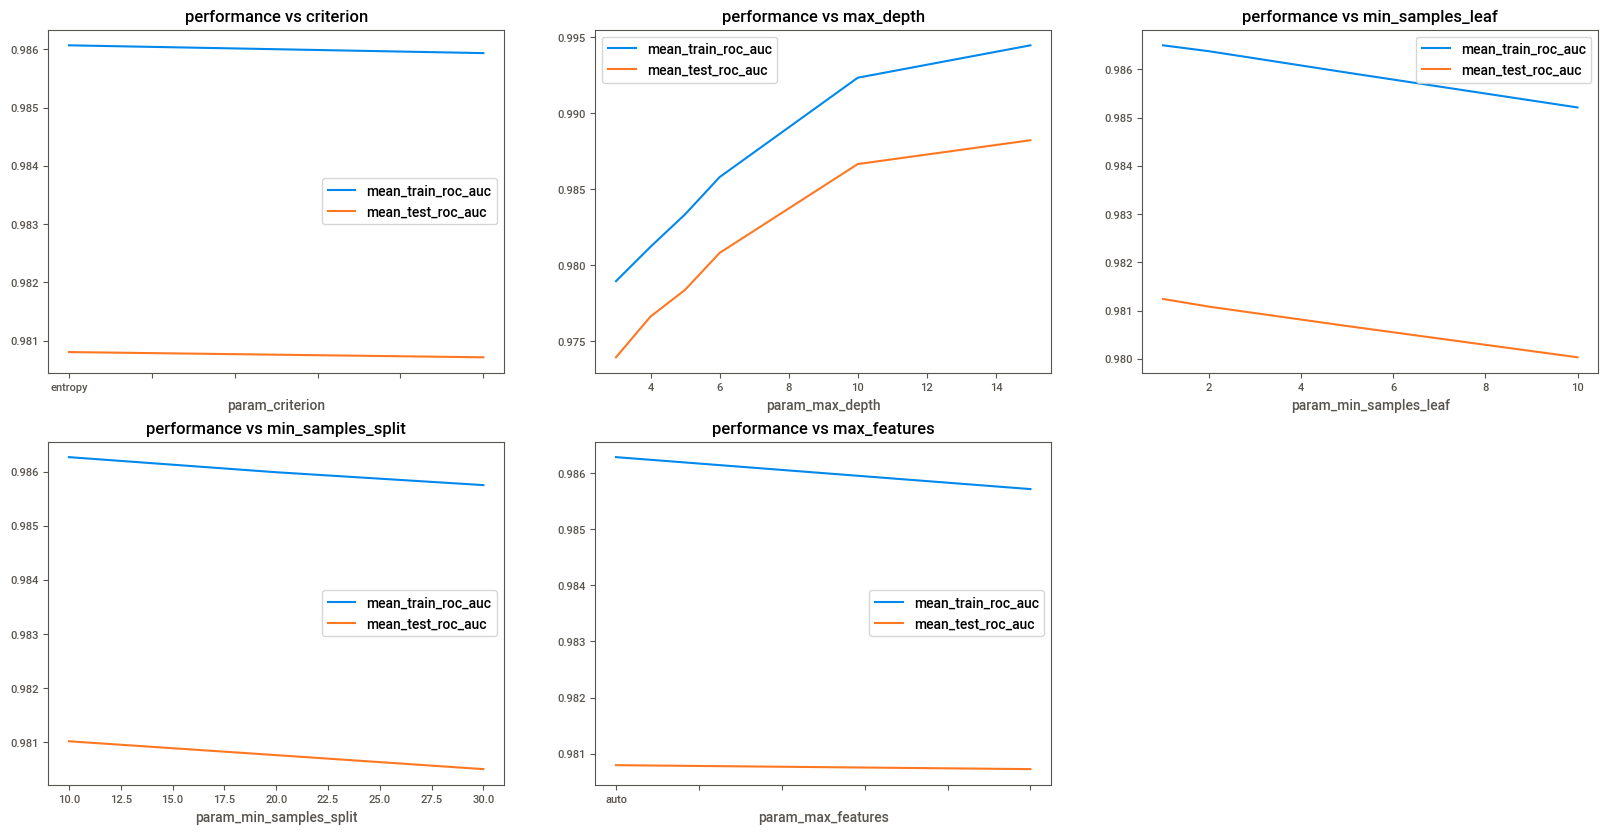

In [ ]:
# Perform the grid search
res_gridcv_rf1 = gridcv_rf1.fit(X, y)
# save the model
dump(gridcv_rf1, root % 'gridcv_rf1.joblib')
dump(res_gridcv_rf1, root % 'res_gridcv_rf1.joblib')

# grid search performance plots
cvdf = pd.DataFrame(gridcv_rf1.cv_results_)
features = parameters.keys()
plt.figure(figsize=(20, 10))
for i, f in enumerate(features):
    ax=plt.subplot(2,3,i+1)
    cvdf.groupby('param_%s'%f)['mean_train_roc_auc', 'mean_test_roc_auc'].mean().plot(ax=ax)
    ax.set_title("performance vs %s"%f)
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  i

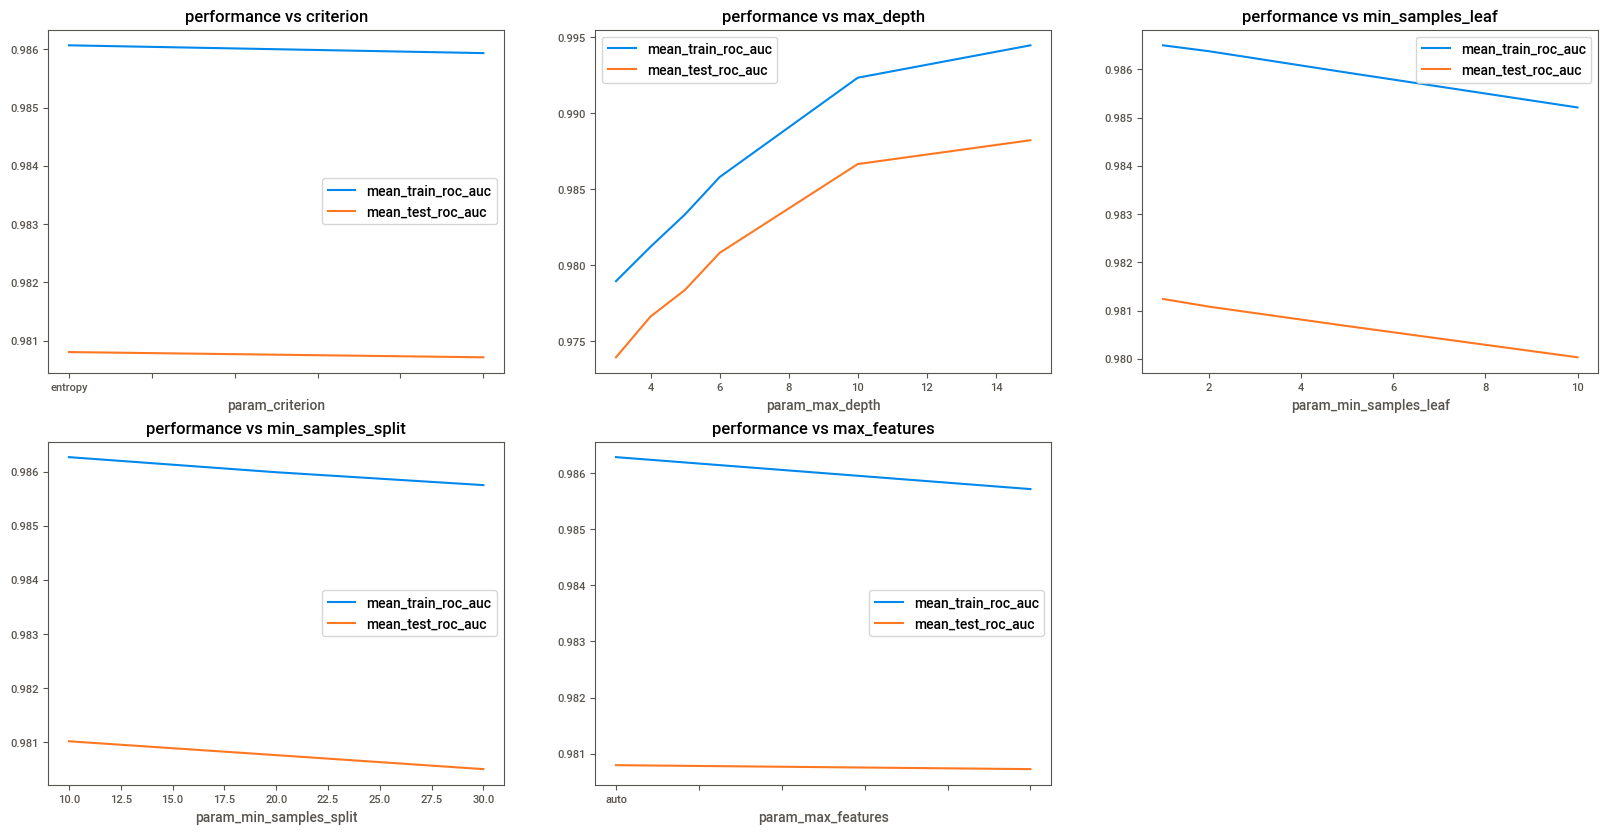

In [ ]:
# grid search performance plots
cvdf = pd.DataFrame(gridcv_rf1.cv_results_)
features = parameters.keys()
plt.figure(figsize=(20, 10))
for i, f in enumerate(features):
    ax=plt.subplot(2,3,i+1)
    cvdf.groupby('param_%s'%f)['mean_train_roc_auc', 'mean_test_roc_auc'].mean().plot(ax=ax)
    ax.set_title("performance vs %s"%f)
plt.show()

## fine tune random forest cv=5

In [ ]:
# decision tree parameter grids
parameters = {
              'max_depth': range(2, 80),
              'min_samples_split' : range(2, 100)
            }

# prepare grid search object
rf2 = RandomForestClassifier(random_state=0, class_weight='balanced',
                            criterion='entropy',
                            max_features='auto',
                            min_samples_leaf=2,
                            )
gridcv_rf2 = RandomizedSearchCV(rf2, 
                                param_distributions=parameters, cv=5, 
                                n_iter=200,
                        scoring = ['roc_auc', 'accuracy', 'recall', 'precision'], refit='roc_auc',
                        error_score='raise', verbose=2, return_train_score=True)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[CV] END .................max_depth=28, min_samples_split=13; total time=   0.5s
[CV] END .................max_depth=28, min_samples_split=13; total time=   0.5s
[CV] END .................max_depth=28, min_samples_split=13; total time=   0.5s
[CV] END .................max_depth=28, min_samples_split=13; total time=   0.5s
[CV] END .................max_depth=28, min_samples_split=13; total time=   0.5s
[CV] END .................max_depth=44, min_samples_split=77; total time=   0.5s
[CV] END .................max_depth=44, min_samples_split=77; total time=   0.5s
[CV] END .................max_depth=44, min_samples_split=77; total time=   0.5s
[CV] END .................max_depth=44, min_samples_split=77; total time=   0.5s
[CV] END .................max_depth=44, min_samples_split=77; total time=   0.5s
[CV] END .................max_depth=59, min_samples_split=56; total time=   0.5s
[CV] END .................max_depth=59, min_s

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  del sys.path[0]


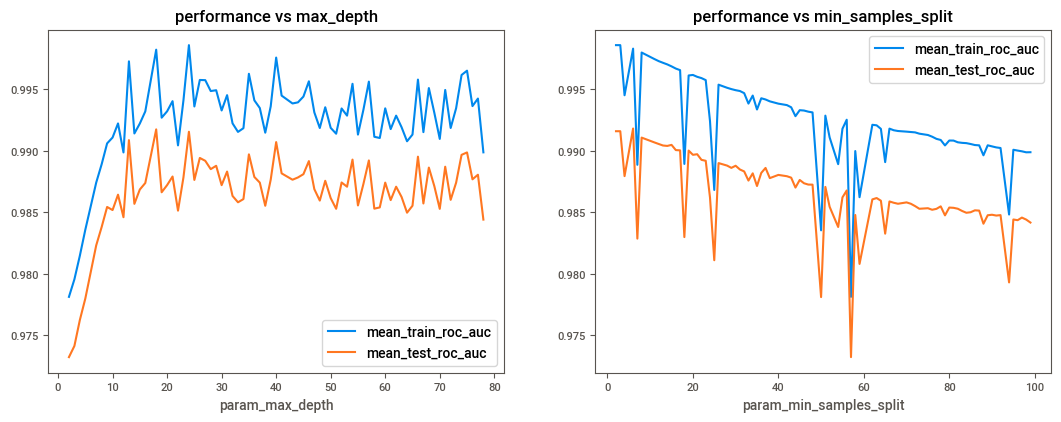

In [ ]:
# Perform the grid search
res_gridcv_rf2 = gridcv_rf2.fit(X, y)
# save the model
dump(gridcv_rf2, root % 'gridcv_rf2.joblib')
dump(res_gridcv_rf2, root % 'res_gridcv_rf2.joblib')
# grid search result
cvdf = pd.DataFrame(gridcv_rf2.cv_results_)
# grid search performance plots
features = parameters.keys()
plt.figure(figsize=(20, 10))
for i, f in enumerate(features):
    ax=plt.subplot(2,3,i+1)
    cvdf.groupby('param_%s'%f)['mean_train_roc_auc', 'mean_test_roc_auc'].mean().plot(ax=ax)
    ax.set_title("performance vs %s"%f)
plt.show()

In [ ]:
# best model
gridcv_rf2.best_estimator_

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=66, min_samples_leaf=2, min_samples_split=6,
                       random_state=0)

In [63]:
# prepare grid search object
rf3 = RandomForestClassifier(random_state=0, class_weight='balanced',
                            criterion='entropy',
                            max_features='auto',
                            min_samples_leaf=2,
                            max_depth=10,
                            min_samples_split=2,
                            )
rf3.fit(X, y)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=10, min_samples_leaf=2, random_state=0)

# XGBoost

In [ ]:
import numpy as np

from scipy.stats import uniform, randint

from sklearn.datasets import load_breast_cancer, load_diabetes, load_wine
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split

import xgboost as xgb


## XGBoost Hyperparameter Tune

In [ ]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic", 
                              random_state=42,
                              scoring="auc")

parameters = {
    "learning_rate": uniform(0.03, 0.3), # default 0.1 
    "max_depth": randint(2, 6), # default 3
    "n_estimators": randint(100, 150), # default 100
    "subsample": uniform(0.6, 0.4)
}

search = RandomizedSearchCV(xgb_model, 
                            param_distributions=parameters, 
                            random_state=42, n_iter=200, cv=5, verbose=2, 
                            n_jobs=1, 
                            return_train_score=True)

search.fit(X, y)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[CV] END learning_rate=0.14236203565420874, max_depth=2, n_estimators=114, subsample=0.892797576724562; total time=   0.3s
[CV] END learning_rate=0.14236203565420874, max_depth=2, n_estimators=114, subsample=0.892797576724562; total time=   0.4s
[CV] END learning_rate=0.14236203565420874, max_depth=2, n_estimators=114, subsample=0.892797576724562; total time=   0.4s
[CV] END learning_rate=0.14236203565420874, max_depth=2, n_estimators=114, subsample=0.892797576724562; total time=   0.4s
[CV] END learning_rate=0.14236203565420874, max_depth=2, n_estimators=114, subsample=0.892797576724562; total time=   0.4s
[CV] END learning_rate=0.20959754525911098, max_depth=4, n_estimators=118, subsample=0.6399899663272012; total time=   0.7s
[CV] END learning_rate=0.20959754525911098, max_depth=4, n_estimators=118, subsample=0.6399899663272012; total time=   0.8s
[CV] END learning_rate=0.20959754525911098, max_depth=4, n_estimators=118

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(random_state=42, scoring='auc'),
                   n_iter=200, n_jobs=1,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ff209a9db90>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ff209a9d050>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ff209a9dd50>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ff208f59e50>},
                   random_state=42, return_train_score=True, verbose=2)

### Tuning Result

In [ ]:
# grid search performance plots
# grid search result
cvdf = pd.DataFrame(search.cv_results_)
# display(cvdf.columns)
features = parameters.keys()
plt.figure(figsize=(20, 10))
for i, f in enumerate(features):
    ax=plt.subplot(2,3,i+1)
    print('param_%s'%f)
    cvdf.groupby('param_%s'%f)['mean_train_score', 'mean_test_score'].mean().plot(ax=ax)
    ax.set_title("AUC vs %s"%f)
plt.show()
# features = parameters.keys()
# plt.figure(figsize=(20, 10))
# for i, f in enumerate(features):
#     ax=plt.subplot(2,3,i+1)
#     cvdf.groupby('param_%s'%f)['mean_train_neg_log_loss', 'mean_test_neg_log_loss'].mean().plot(ax=ax)
#     ax.set_title("Negative Log Loss vs %s"%f)
# plt.show()

param_learning_rate
param_max_depth
param_n_estimators


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  # Remove the CWD from sys.path while we load stuff.


param_subsample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  # Remove the CWD from sys.path while we load stuff.


In [132]:
uniform(0.95 , 1.0)

## XGBoost Hyperparameter Fine-Tune

In [136]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic", 
                              random_state=42,
                              n_estimators=126,
                              scoring="auc")

parameters = {
    "learning_rate": np.linspace(0.08, 0.1, 10), # default 0.1 
    "max_depth": np.arange(5, 10, 1), # default 3
    "n_estimators": np.arange(125, 135, 1), # default 100
    "subsample": np.linspace(0.95 , 1.0, 10)
}

search = RandomizedSearchCV(xgb_model, 
                            param_distributions=parameters, 
                            random_state=42, n_iter=500, cv=5, verbose=2, 
                            n_jobs=1, 
                            return_train_score=True)

# fit
search.fit(X, y)
# grid search performance plots
# grid search result
cvdf = pd.DataFrame(search.cv_results_)
# display(cvdf.columns)
features = parameters.keys()
plt.figure(figsize=(20, 10))
for i, f in enumerate(features):
    ax=plt.subplot(2,3,i+1)
    print('param_%s'%f)
    cvdf.groupby('param_%s'%f)['mean_train_score', 'mean_test_score'].mean().plot(ax=ax)
    ax.set_title("AUC vs %s"%f)
plt.show()
# features = parameters.keys()
# plt.figure(figsize=(20, 10))
# for i, f in enumerate(features):
#     ax=plt.subplot(2,3,i+1)
#     cvdf.groupby('param_%s'%f)['mean_train_neg_log_loss', 'mean_test_neg_log_loss'].mean().plot(ax=ax)
#     ax.set_title("Negative Log Loss vs %s"%f)
# plt.show()

Fitting 5 folds for each of 500 candidates, totalling 2500 fits
[16:34:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[CV] END learning_rate=0.08666666666666667, max_depth=5, n_estimators=125, subsample=0.9555555555555555; total time=   0.6s
[16:34:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you fin

C:\Users\DNDLSS~1\AppData\Local\Temp/ipykernel_15836/313448216.py:30: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  cvdf.groupby('param_%s'%f)['mean_train_score', 'mean_test_score'].mean().plot(ax=ax)
C:\Users\DNDLSS~1\AppData\Local\Temp/ipykernel_15836/313448216.py:30: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  cvdf.groupby('param_%s'%f)['mean_train_score', 'mean_test_score'].mean().plot(ax=ax)
C:\Users\DNDLSS~1\AppData\Local\Temp/ipykernel_15836/313448216.py:30: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  cvdf.groupby('param_%s'%f)['mean_train_score', 'mean_test_score'].mean().plot(ax=ax)
C:\Users\DNDLSS~1\AppData\Local\Temp/ipykernel_15836/313448216.py:30: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys)

## XGBoost Final Model

In [17]:
top8 = [
    'having_IP',
 'Google_Index',
 'SFH',
 'Links_pointing_to_page',
 'URL_of_Anchor',
 'Request_URL',
 'Links_in_tags',
 'SSLfinal_State']

In [33]:
import warnings
warnings.filterwarnings('ignore')

In [56]:
# build finetuned xgb model
xgb_model3 = xgb.XGBClassifier(objective="binary:logistic", 
                              random_state=42,
                              scoring="auc",
                              learning_rate= 0.94,
                              max_depth=15,
                              n_estimators=127,
                              subsample=0.965,
                              )

xgb_result = xgb_model3.fit(X, y)
model = xgb_model3
auc = metrics.roc_auc_score(y, model.predict_proba(X)[:,1])
print(auc)
print((9997774237814413 - int(10e15*auc)))
# 0.9997774237814413

[13:06:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[13:06:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.9997774237814412
1


# PyTorch NN

In [123]:
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split


x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

x_train = torch.from_numpy(x_train.to_numpy().astype("float32"))
x_test = torch.from_numpy(x_test.to_numpy().astype("float32"))
y_train = torch.from_numpy(y_train.to_numpy().astype("float32"))
y_test = torch.from_numpy(y_test.to_numpy().astype("float32"))
y_train = y_train.view(-1, 1)
y_test = y_test.view(-1, 1)

class MyDataset(Dataset):
    def __init__(self):
        self.n_samples = x_train.shape[0]

    def __getitem__(self, idx):
        return x_train[idx], y_train[idx]
    
    def __len__(self):
        return self.n_samples
# MyDataset()

In [124]:
# define performance metric
def evaluation_metric(pred_proba, actual, cutoff=0.5):
    with torch.no_grad():
        auc_scor = metrics.roc_auc_score(actual, pred_proba)
        return auc_scor
def eval_(x_, y_):
    # train eval
    y_h = model(x_)
    l_ = criterion(y_h, y_)
    perf_ = evaluation_metric(y_h, y_)
    return l_, perf_

### Initialize training variable

In [133]:
# model building

feature_inp = 30
classes = 1
model = nn.Sequential(
    nn.Linear(feature_inp, 30, dtype=torch.float32),
    nn.ReLU(),
    # nn.Linear(30, 100, dtype=torch.float32),
    # nn.ReLU(),
    # nn.Linear(100, 30, dtype=torch.float32),
    # nn.ReLU(),
    nn.Linear(30, classes, dtype=torch.float32),
    nn.Softmax()
)

import math
# load dataset
mydataset = MyDataset()

# data loader
batch_size = 100
num_batch = math.ceil(len(mydataset) / batch_size)
dataloader = DataLoader(dataset = mydataset, batch_size=batch_size, shuffle=True)

# loss function
criterion = nn.BCELoss()

# optimizer
lern_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=lern_rate)

### Continue Training

In [138]:
# training loop
epoch_start = 1
num_epoch = 10
step_print = 1

for epoch in range(epoch_start, num_epoch):
    for batch, (x_fet, y_act) in enumerate(dataloader):
        # forward pass
        y_hat = model(x_fet)

        # calculate loss
        loss = criterion(y_hat, y_act)

        # gradients calculate
        loss.backward()

        # weigth update
        optimizer.step()

        # clear gradients
        optimizer.zero_grad()
        with torch.no_grad():
            train_perf_ = evaluation_metric(y_hat, y_act)

    if (epoch+1) % step_print == 0:    
        with torch.no_grad():
            # train eval
            train_loss, train_auc = eval_(x_train, y_train)
            # test evaluation
            test_loss, test_auc = eval_(x_test, y_test)

            print(f"Epoch-{epoch}/{num_epoch} "
                  f"train_loss={loss} train_auc:{train_perf_} "
                  f"test_loss={test_loss} test_auc:{test_auc} ")

Epoch-1/10 train_loss=32.65306091308594 train_auc:0.5 test_loss=47.28434371948242 test_auc:0.5 
Epoch-2/10 train_loss=46.93877410888672 train_auc:0.5 test_loss=47.28434371948242 test_auc:0.5 
Epoch-3/10 train_loss=55.1020393371582 train_auc:0.5 test_loss=47.28434371948242 test_auc:0.5 
Epoch-4/10 train_loss=55.1020393371582 train_auc:0.5 test_loss=47.28434371948242 test_auc:0.5 
Epoch-5/10 train_loss=61.224491119384766 train_auc:0.5 test_loss=47.28434371948242 test_auc:0.5 
Epoch-6/10 train_loss=51.020408630371094 train_auc:0.5 test_loss=47.28434371948242 test_auc:0.5 
Epoch-7/10 train_loss=46.93877410888672 train_auc:0.5 test_loss=47.28434371948242 test_auc:0.5 
Epoch-8/10 train_loss=40.81632614135742 train_auc:0.5 test_loss=47.28434371948242 test_auc:0.5 
Epoch-9/10 train_loss=55.1020393371582 train_auc:0.5 test_loss=47.28434371948242 test_auc:0.5 


# Model Performance Eval.

In [233]:
# model = search.best_estimator_
# model = gridcv_dt7.best_estimator_
# model = dt8
# model = gridcv_dt8.best_estimator_
# model = gridcv_rf1.best_estimator_
# model = gridcv_rf2.best_estimator_
# model = rf3
# model = dt6
# model = lrcv_rfe
# model = dt6
model = xgb_model3

print(metrics.roc_auc_score(y, model.predict_proba(X)[:,1]))
metrics.plot_roc_curve(model, X, y)
plt.title("ROC_AUC")
plt.show()
# 0.9997774237814413

0.9997774237814412


C:\Users\dndlssardar\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


In [203]:
# calculate probability values
y_train_proba =pd.Series(model.predict_proba(X)[:, 1])

# prepare a dataframe
y_train_final = pd.DataFrame(columns=['phishing', 'proba'])

y_train_final['phishing'] = np.array(y)
y_train_final['proba'] = y_train_proba
# calculate prediction for different probability values
cutoff_range= np.arange(0, 1.001, 0.001)
for i in cutoff_range:
    y_train_final[f"{round(i,2)}"] = y_train_proba.apply(lambda x: 1 if x >= i else 0)


C:\Users\DNDLSS~1\AppData\Local\Temp/ipykernel_15836/1654706097.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  y_train_final[f"{round(i,2)}"] = y_train_proba.apply(lambda x: 1 if x >= i else 0)


In [204]:
# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['cutoff', 'accuracy', 'sensi', 'speci','false negative rate', 'false positive rate'])
for i in cutoff_range:
    cm1 = metrics.confusion_matrix(y_train_final["phishing"], y_train_final[f"{round(i,2)}"] )
    total1=sum(sum(cm1))
    # metrics
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    false_negative_rate = 1-sensi
    false_positive_rate = 1-speci
    # update dataframe
    cutoff_df.loc[i] =[i, accuracy, sensi, speci, false_negative_rate, false_positive_rate]
cutoff_df.sample(2)

cutoff  accuracy     sensi     speci  false negative rate  \
0.344   0.344  0.989451  1.000000  0.978641             0.000000   
0.404   0.404  0.989451  0.998863  0.979806             0.001137   

       false positive rate  
0.344             0.021359  
0.404             0.020194

## "Accuracy vs FN Rate vs FP Rate" Plots

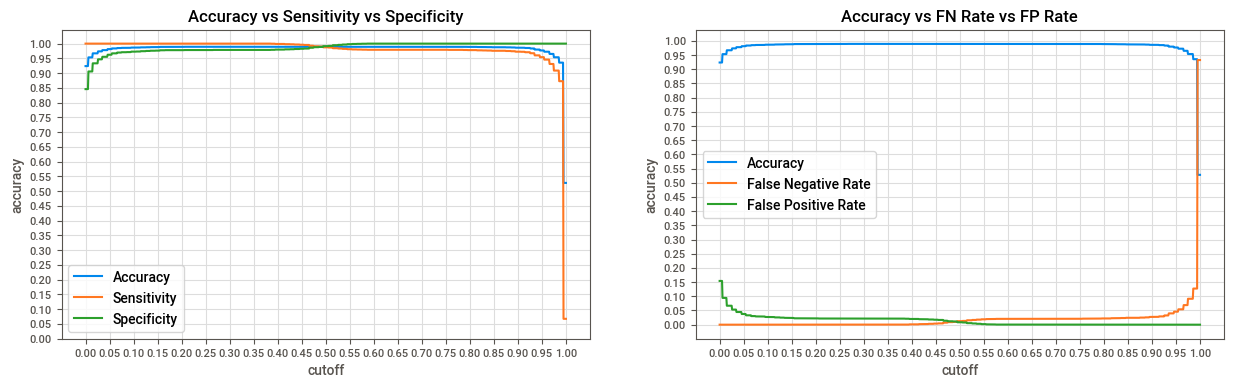

In [205]:
# metric comparison polt
plt.figure(figsize=[15, 9])
ax = plt.subplot(2,2,1)
ax.set_title("Accuracy vs Sensitivity vs Specificity")
sns.lineplot(data=cutoff_df, x="cutoff", y="accuracy", label="Accuracy")
sns.lineplot(data=cutoff_df, x="cutoff", y="sensi", label="Sensitivity")
sns.lineplot(data=cutoff_df, x="cutoff", y="speci", label="Specificity")
ax.set_xticks(np.arange(0, 1.05, 0.05))
ax.set_yticks(np.arange(0, 1.05, 0.05))
ax.grid(visible=True, color="#dddddd")
ax = plt.subplot(2,2,2)
ax.set_title("Accuracy vs FN Rate vs FP Rate")
sns.lineplot(data=cutoff_df, x="cutoff", y="accuracy", label="Accuracy")
sns.lineplot(data=cutoff_df, x="cutoff", y="false negative rate", label="False Negative Rate")
sns.lineplot(data=cutoff_df, x="cutoff", y="false positive rate", label="False Positive Rate")
ax.grid(visible=True, color="#dddddd")
ax.set_xticks(np.arange(0, 1.05, 0.05))
ax.set_yticks(np.arange(0, 1.05, 0.05))
plt.show()

## Optimal `probability cutoff` for prediction

In [206]:
# optimal cutoff finding
closest = np.argmin(np.array(cutoff_df["false positive rate"] - cutoff_df["false negative rate"])**2)
optimal = pd.DataFrame(cutoff_df.iloc[closest]).T
optimal

cutoff  accuracy     sensi     speci  false negative rate  \
0.486   0.486  0.989451  0.990148  0.988738             0.009852   

       false positive rate  
0.486             0.011262

In [207]:
# optimal values
optimal = round(optimal, 3)
print("Optimal Probability cutoff: ", optimal['cutoff'].values)
print("Accuracy at optimal cutoff: ", optimal['accuracy'].values)
print("Sensitivity at optimal cutoff: ", optimal['sensi'].values)
print("Specificity at optimal cutoff: ", optimal['speci'].values)
print("FNR at optimal cutoff: ", optimal['false negative rate'].values)
print("FPR at optimal cutoff: ", optimal['false positive rate'].values)

Optimal Probability cutoff:  [0.486]
Accuracy at optimal cutoff:  [0.989]
Sensitivity at optimal cutoff:  [0.99]
Specificity at optimal cutoff:  [0.989]
FNR at optimal cutoff:  [0.01]
FPR at optimal cutoff:  [0.011]


### Final result submission

In [247]:
y_pred = pd.Series(model.predict_proba(test_enc)[:, 1])
submit = pd.DataFrame(dict(key=test_key, 
        Result=y_pred.apply(lambda pred: -1 if pred >= 0.6 else 1))
)

# load compare mat
comp_df = pd.read_csv("compare_mat.csv")

assert sum(comp_df[comp_df["Result"] == -99].key == submit[comp_df["Result"] == -99].key) == 653

comp_df.loc[comp_df["Result"] == -99, "Result"] = submit.loc[comp_df["Result"] == -99, "Result"]

# save the result
submit.to_csv("submission_xgb3cv_6.csv", index=None)
comp_df.to_csv("comp_submission_xgb3cv_6.csv", index=None)


# best = pd.read_csv("submission_07-best.csv")
# their = pd.read_csv("sample_submission.csv")
# best["Result"].eq(submit["Result"]).sum()/len(best)

## Final Model Save

In [142]:
# run prediction on test data
y_test_proba = pd.Series(model.predict_proba(test_enc)[:, 1])

In [ ]:
dump(model, root % 'final_model.joblib')

['final_model.joblib']

## Prediction Function

- Use below function to run the prediction.
- Make sure to save `model file` and `feature encoder file`.
- Currently the model file name is: `dt6.joblib`
- Currently the feature encoder file name is: `enc.joblib`
- `Joblib version: 1.1.0`

In [ ]:
root = "/content/drive/MyDrive/TechGig_HPE_ML_2022/%s"
def predict(features, p=0.25):
    """Use this function to predict """
    # load the model
    model = load(root % 'final_model.joblib')
    # load encoder
    enc = load(root % 'enc.joblib')
    encoded = enc.transform(features)
    # display(encoded)
    # run probability
    proba = pd.Series(model.predict_proba(encoded)[:, 1])
    # display()
    # generate and return result
    return proba.apply(lambda x: -1 if x >= p else 1)

# run prediction
predict(test.iloc[:1, :], p=0.25)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


0    1
dtype: int64

# <center>THE END</center>